# Capstone Project: Random Forest Regression: SGCarMart Used Cars Price Predictor

In [99]:
import pandas as pd
import numpy as np
from datetime import date

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import matplotlib.pyplot as plt
import seaborn as sns

### Pre-defined Functions

In [100]:
def plot_corr_matrix_heatmap(df):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(df.corr(), dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure to control size of heatmap
    fig, ax = plt.subplots(figsize=(15, 15))

    # Create a custom color palette
    cmap = sns.diverging_palette(220, 20, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
    # Blue = Good (low correlation), Red = Bad (high correlation) between the independent variables

    # Plot the heatmap
    sns.heatmap(df.corr(), mask=mask, annot=True, square=True, cmap=cmap, vmin=-1, vmax=1, ax=ax)

    # Prevent Heatmap Cut-Off Issue
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    plt.show()

In [101]:
def linear_regression_analysis(X, Y):
    """
    Perform linear regression analysis and return the summary of the results.

    Parameters:
    X (DataFrame): Independent variables (features)
    Y (Series): Dependent variable (target)

    Returns:
    summary: Summary of the regression results
    """
    # Add a constant to the independent variables
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(Y, X)
    results = model.fit()

    # Return the summary of the results
    return results.summary()

In [102]:
def random_forest_analysis(X, Y, n_estimators=200, random_state=42):
    """
    Perform Random Forest regression analysis and return the model's performance metrics.

    Parameters:
    X (DataFrame): Independent variables (features)
    Y (Series): Dependent variable (target)
    n_estimators (int): Number of trees in the forest (default is 100)
    random_state (int): Random seed for reproducibility (default is 42)

    Returns:
    dict: Dictionary containing RMSE and R^2 score
    """
    # Initialize the Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)

    # Fit the model
    rf.fit(X, Y)

    # Predict the target variable
    Y_pred = rf.predict(X)

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(Y, Y_pred))
    r2 = r2_score(Y, Y_pred)

    return {'RMSE': rmse, 'R^2': r2}

### Section 1: DataFrame Loading, Cleaning

In [103]:
# Use the dir() function to view all variables in the current environment.
# Refer to this link for more information: https://stackoverflow.com/questions/633127/viewing-all-defined-variables
# This link provides a solution to view all defined variables in the current environment.

In [104]:
df_main = pd.read_csv('sgcarmart_used_cars_prices.csv',index_col=0)

len(df_main.columns)

20

In [105]:
df_main.sample(10)

LISTING_URL  \
4399  https://www.sgcarmart.com/used_cars/info.php?I...   
4257  https://www.sgcarmart.com/used_cars/info.php?I...   
5532  https://www.sgcarmart.com/used_cars/info.php?I...   
183   https://www.sgcarmart.com/used_cars/info.php?I...   
521   https://www.sgcarmart.com/used_cars/info.php?I...   
3838  https://www.sgcarmart.com/used_cars/info.php?I...   
5613  https://www.sgcarmart.com/used_cars/info.php?I...   
6315  https://www.sgcarmart.com/used_cars/info.php?I...   
6079  https://www.sgcarmart.com/used_cars/info.php?I...   
38    https://www.sgcarmart.com/used_cars/info.php?I...   

                                            BRAND     PRICE  DEPRE_YEARLY  \
4399                   KIA CERATO K3 1.6A SUNROOF   37800.0       11470.0   
4257             SKODA KAROQ 1.5 TSI AMBITION (A)   92688.0       16490.0   
5532          TOYOTA ALPHARD 2.5 CVT ELEGANCE S/R   92500.0       29930.0   
183                           HONDA FIT 1.3GF CVT   70800.0       13060.0   
521            MERCEDES BENZ C180 COUPE (R17 LED)  129800.0       21620.0   
3838                 TOYOTA VOXY HYBRID 1.8SZ CVT  211800.0       21760.0   
5613                                          NaN  198800.0       20500.0   
6315  RENAULT GRAND SCENIC IV 1.5 DCI AT EU6 BOSE   86888.0       14850.0   
6079   NISSAN SYLPHY 1.6 CVT ABS D/AIRBAG 2WD 4DR   55900.0       11870.0   
38                   HONDA VEZEL HYBRID 1.5X AUTO   42800.0       13930.0   

         REG_DATE  MILEAGE_KM MANUFACTURED_YEAR  ROAD_TAX_YEARLY TRANSMISSION  \
4399  19-Apr-2017    106000.0              2017            738.0         Auto   
4257  02-Aug-2019     54900.0              2019            684.0         Auto   
5532  14-Nov-2016    150000.0              2016           1792.0         Auto   
183   21-Nov-2019     51000.0              2019            578.0         Auto   
521   19-Jul-2019    101000.0              2019            740.0         Auto   
3838  28-Dec-2023        80.0               MPV            974.0         2023   
5613  26-May-2014     99800.0              2013           6860.0         Auto   
6315  28-Nov-2019     75674.0               MPV           1048.0         2019   
6079  28-Jun-2014         NaN              2014            816.0         Auto   
38    08-Aug-2017     77426.0               SUV            682.0         2016   

      DEREG_VALUE_FROM_SCRAPE_DATE SCRAPE_DATE       OMV       ARF  \
4399                       23126.0  15/09/2024   16207.0   16207.0   
4257                       36317.0  15/09/2024   23152.0   24413.0   
5532                       45541.0  15/09/2024   45431.0   55604.0   
183                        20206.0  15/09/2024   16207.0    6207.0   
521                        54436.0  15/09/2024   41636.0   50291.0   
3838                      102571.0  15/09/2024       NaN       NaN   
5613                       79293.0  15/09/2024  105254.0  161458.0   
6315                       31063.0  15/09/2024       NaN       NaN   
6079                       39820.0  15/09/2024   15243.0   10243.0   
38                         17466.0  15/09/2024       NaN       NaN   

      COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT  ENGINE_CAPACITY_CC  \
4399               51765.0             792.0              1591.0   
4257               39406.0            1584.0              1498.0   
5532               56340.0             792.0              2494.0   
183                30000.0            1980.0              1317.0   
521                39728.0            1584.0              1595.0   
3838              110001.0            3564.0              1797.0   
5613               99116.0            3564.0              5461.0   
6315               32000.0            1980.0              1461.0   
6079               42275.0            1584.0              1598.0   
38                 50001.0             792.0              1496.0   

      CURB_WEIGHT_KG  NO_OF_OWNERS     VEHICLE_TYPE        FUEL_TYPE  
4399          1295.0           4.0  Mid-Sized Sedan           P

In [106]:
print(df_main.columns)

Index(['LISTING_URL', 'BRAND', 'PRICE', 'DEPRE_YEARLY', 'REG_DATE',
       'MILEAGE_KM', 'MANUFACTURED_YEAR', 'ROAD_TAX_YEARLY', 'TRANSMISSION',
       'DEREG_VALUE_FROM_SCRAPE_DATE', 'SCRAPE_DATE', 'OMV', 'ARF',
       'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT', 'ENGINE_CAPACITY_CC',
       'CURB_WEIGHT_KG', 'NO_OF_OWNERS', 'VEHICLE_TYPE', 'FUEL_TYPE'],
      dtype='object')


In [107]:
df_clean = df_main.drop(['LISTING_URL', 'SCRAPE_DATE'],axis=1) #Drop columns that were used for reference purposes.
# There are NA entries in the dataset.
# Dropping these NA values is necessary to avoid future problems.
# Null values may occur due to missing data or formatting issues in the car listings.
# Varying ways of organizing information in a single listing can contribute to these formatting issues.

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9926 entries, 0 to 9925
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   BRAND                         9384 non-null   object 
 1   PRICE                         9708 non-null   float64
 2   DEPRE_YEARLY                  9567 non-null   float64
 3   REG_DATE                      9917 non-null   object 
 4   MILEAGE_KM                    8342 non-null   float64
 5   MANUFACTURED_YEAR             9917 non-null   object 
 6   ROAD_TAX_YEARLY               9801 non-null   float64
 7   TRANSMISSION                  9917 non-null   object 
 8   DEREG_VALUE_FROM_SCRAPE_DATE  9094 non-null   float64
 9   OMV                           8340 non-null   float64
 10  ARF                           8350 non-null   float64
 11  COE_FROM_SCRAPE_DATE          9349 non-null   float64
 12  DAYS_OF_COE_LEFT              9883 non-null   float64
 13  ENGINE_C

In [108]:
df_clean.sample(10)

BRAND     PRICE  DEPRE_YEARLY  \
4217          TOYOTA HARRIER 2.0 SUV (AUTO) (2WD)  180800.0       19620.0   
9319             MERCEDES BENZ SLK 200 KOMPRESSOR   59300.0       13050.0   
3013                                          NaN   22800.0       11300.0   
3659    TOYOTA WISH 1.8X CVT ABS D/AIRBAG 2WD 5DR   44800.0       15270.0   
2470                      HONDA CIVIC 1.6 VTI CVT   61800.0       14340.0   
5636      VOLKSWAGEN TOURAN 1.4 TSI CL 5T13NZ HLG   94888.0       16310.0   
5733  MAZDA MAZDA2 SEDAN 1.5 AT STANDARD PLUS EU6   50800.0       13120.0   
4344                HYUNDAI AD AVANTE 1.6 GLS (A)   70800.0       12500.0   
2307                                          NaN  128888.0       18300.0   
2942                      HYUNDAI HD AVANTE 1.6 M   35800.0        7740.0   

         REG_DATE  MILEAGE_KM MANUFACTURED_YEAR  ROAD_TAX_YEARLY TRANSMISSION  \
4217  03-Nov-2022     44700.0              2021           1198.0         Auto   
9319  17-Apr-2009         NaN              2008           1461.0         Auto   
3013  17-Feb-2016    118850.0              2015            508.0         Auto   
3659  20-Dec-2016    110000.0              2016            974.0         Auto   
2470  30-Apr-2018    112154.0              2018            742.0         Auto   
5636  30-Sep-2019     69243.0              2019            624.0         Auto   
5733  22-May-2018     55000.0              2018            682.0         Auto   
4344  06-Nov-2019     70000.0              2019            738.0         Auto   
2307  03-Oct-2011    149000.0              2011           4319.0         Auto   
2942  10-Jun-2009    178000.0              2009           1107.0       Manual   

      DEREG_VALUE_FROM_SCRAPE_DATE      OMV      ARF  COE_FROM_SCRAPE_DATE  \
4217                      117322.0  35925.0  42295.0              107001.0   
9319                       14998.0  50330.0  50330.0               33018.0   
3013                       14033.0  18454.0  13454.0               46651.0   
3659                       24326.0  20412.0  20577.0               53001.0   
2470                       26182.0  19724.0  19724.0               36890.0   
5636                       37675.0  23831.0  25364.0               37000.0   
5733                       14157.0  14427.0   5000.0               29622.0   
4344                       26379.0  13019.0  13019.0               32309.0   
2307                       40942.0  76104.0  76104.0               58124.0   
2942                       12105.0   9306.0   9306.0               26175.0   

      DAYS_OF_COE_LEFT  ENGINE_CAPACITY_CC  CURB_WEIGHT_KG  NO_OF_OWNERS  \
4217            3168.0              1987.0          1580.0           1.0   
9319            1584.0              1796.0          1415.0           6.0   
3013             396.0              1197.0          1285.0           2.0   
3659             792.0              1797.0          1350.0           2.0   
2470            1188.0              1597.0          1249.0           2.0   
5636            1830.0              1395.0          1288.0           1.0   
5733            1188.0              1496.0          1102.0           1.0   
4344            1980.0              1591.0          1345.0           3.0   
2307            2562.0              3598.0          2105.0           2.0   
2942            1584.0              1591.0          1264.0           4.0   

         VEHICLE_TYPE FUEL_TYPE  
4217              SUV    Petrol  
9319       Sports Car    Petrol  
3013              SUV       NaN  
3659              MPV    Petrol  
2470  Mid-Sized Sedan    Petrol  
5636              MPV    Petrol  
5733  Mid-Sized Sedan    Petrol  
4344  Mid-Sized Sedan    Petrol  
2307              SUV       NaN  
2942  Mid-Sized Sedan    Petrol

In [109]:
# After dropping null values, we have rows of data remaining
df_clean.dropna(inplace=True)

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5888 entries, 1 to 9925
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   BRAND                         5888 non-null   object 
 1   PRICE                         5888 non-null   float64
 2   DEPRE_YEARLY                  5888 non-null   float64
 3   REG_DATE                      5888 non-null   object 
 4   MILEAGE_KM                    5888 non-null   float64
 5   MANUFACTURED_YEAR             5888 non-null   object 
 6   ROAD_TAX_YEARLY               5888 non-null   float64
 7   TRANSMISSION                  5888 non-null   object 
 8   DEREG_VALUE_FROM_SCRAPE_DATE  5888 non-null   float64
 9   OMV                           5888 non-null   float64
 10  ARF                           5888 non-null   float64
 11  COE_FROM_SCRAPE_DATE          5888 non-null   float64
 12  DAYS_OF_COE_LEFT              5888 non-null   float64
 13  ENGINE_C

In [110]:
df_clean.sample(10)

BRAND     PRICE  \
116                                HONDA HRV 1.5 LX CVT   38888.0   
4836                                 TOYOTA VIOS E AUTO   53388.0   
2940            MINI COOPER 1.6 AT ABS D/AIRBAG 2WD 3DR   67800.0   
8496                       MINI ONE 3DR HB PGR (LCI FL)  109900.0   
9916                             HONDA N-BOX L 660 AUTO  142800.0   
4454                           AUDI Q5 2.0 TFSI QUATTRO   85000.0   
2891  MERCEDES BENZ A200 COMPT SALN PROGRESSIVE (R18...  106800.0   
7665        KIA CERATO FORTE 1.6 SX MT ABS D/AB 2WD 4DR   44800.0   
3011                TOYOTA ESTIMA AERAS PREMIUM 2.4 CVT   94800.0   
8188                VOLVO V90 CROSS COUNTRY T5 MOMENTUM  103777.0   

      DEPRE_YEARLY     REG_DATE  MILEAGE_KM MANUFACTURED_YEAR  \
116        13830.0  17-Oct-2016    117288.0              2016   
4836        9150.0  16-Jul-2010    142000.0              2010   
2940        9400.0  29-Mar-2012    122415.0              2011   
8496       17430.0  19-Jun-2020     54000.0              2020   
9916       15140.0  21-Dec-2023        39.0              2022   
4454       14060.0  21-Apr-2011     50000.0              2011   
2891       20220.0  24-Jan-2019     84800.0              2018   
7665        8650.0  19-Nov-2009     82841.0              2009   
3011       22160.0  18-Dec-2017     83000.0              2017   
8188       22060.0  18-Apr-2018    117562.0              2017   

      ROAD_TAX_YEARLY TRANSMISSION  DEREG_VALUE_FROM_SCRAPE_DATE      OMV  \
116             682.0         Auto                       22491.0  23650.0   
4836           1026.0         Auto                       19176.0  12306.0   
2940            965.0         Auto                       34443.0  22309.0   
8496            684.0         Auto                       33076.0  26423.0   
9916            326.0         Auto                       74166.0  15456.0   
4454           1672.0         Auto                       21114.0  45025.0   
2891            586.0         Auto                       39634.0  32368.0   
7665           1107.0       Manual                       16785.0  12611.0   
3011           1638.0         Auto                       46970.0  38119.0   
8188           1176.0         Auto                       45958.0  40836.0   

          ARF  COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT  ENGINE_CAPACITY_CC  \
116   20110.0               50000.0             792.0              1496.0   
4836  12306.0               32875.0            1975.0              1497.0   
2940  22309.0               47765.0            2772.0              1598.0   
8496  18993.0               32699.0            1980.0              1499.0   
9916   5000.0               88020.0            3564.0               658.0   
4454  45025.0               34935.0            2196.0              1984.0   
2891  37316.0               31001.0            1584.0              1332.0   
7665  12358.0               32416.0            1980.0              1591.0   
3011  45367.0               53711.0            1188.0              2362.0   
8188  49171.0               39000.0            1188.0              1969.0   

      CURB_WEIGHT_KG  NO_OF_OWNERS     VEHICLE_TYPE FUEL_TYPE  
116           1190.0           1.0              SUV    Petrol  
4836          1095.0           3.0  Mid-Sized Sedan    Petrol  
2940          1105.0           2.0        Hatchback    Petrol  
8496          1170.0           1.0        Hatchback    Petrol  
9916           900.0           1.0        Hatchback    Petrol  
4454          1740.0           3.0              SUV    Petrol  
2891          1375.0           2.0        Hatchback    Petrol  
7665          1227.0           1.0  Mid-Sized Sedan    Petrol  
3011          1800.0           1.0              MPV    Petrol  
8188          1856.0           1.0     Stationwagon    Petrol

In [111]:
# 18 variables in columns after cleaning
print(df_clean.columns,'\n',len(df_clean.columns))

Index(['BRAND', 'PRICE', 'DEPRE_YEARLY', 'REG_DATE', 'MILEAGE_KM',
       'MANUFACTURED_YEAR', 'ROAD_TAX_YEARLY', 'TRANSMISSION',
       'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV', 'ARF', 'COE_FROM_SCRAPE_DATE',
       'DAYS_OF_COE_LEFT', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'VEHICLE_TYPE', 'FUEL_TYPE'],
      dtype='object') 
 18


## Section 2: Data Categorizing

### Section 2.1: One-hot encoding TRANSMISSION/ VEHICLE TYPE/ FUEL TYPE ColumnS

In [112]:
#The transmission options in this dataset are limited to Auto or Manual.
#To handle this, apply one-hot encoding to represent the transmission variable.
df_clean['TRANSMISSION'].value_counts()

TRANSMISSION
Auto      5819
Manual      69
Name: count, dtype: int64

In [113]:
# Transmission conversion -> 1 for auto, 0 for manual (just 1 column only)
df_clean['TRANSMISSION_CONVERT'] = df_clean['TRANSMISSION'].apply(lambda x: 1 if x == 'Auto' else 0)
df_clean.drop('TRANSMISSION',axis=1,inplace=True)
df_clean.rename(columns={'TRANSMISSION_CONVERT':"TRANSMISSION"}, inplace=True)  # Renaming column back

In [114]:
df_clean.sample(10)

BRAND     PRICE  DEPRE_YEARLY  \
5557                           HONDA VEZEL 1.5G CVT  145800.0       16690.0   
7422  B.M.W. 325I AT 2.5L ABS D/AB GAS/D 2WD 4DR SR   64800.0       11740.0   
7470                         MERCEDES BENZ E 250CGI   70800.0       12990.0   
5468                            AUDI A4 1.8 TFSI MU   69800.0       10540.0   
1660                          MERCEDES BENZ C180 ML   30800.0       14510.0   
1449                           HONDA VEZEL 1.5G CVT  144800.0       15890.0   
7416                   MASERATI QUATTROPORTE 3.0 V6  308888.0       37020.0   
533                             MERCEDES BENZ SL450   59888.0       12400.0   
6225                            HONDA FIT 1.3GF CVT   75800.0       13370.0   
2594               SUBARU IMPREZA 4D 1.6I-S AWD CVT   40800.0       13060.0   

         REG_DATE  MILEAGE_KM MANUFACTURED_YEAR  ROAD_TAX_YEARLY  \
5557  13-Apr-2023     36288.0              2022            682.0   
7422  23-Mar-2010    136831.0              2010           2694.0   
7470  26-Feb-2010    103680.0              2009           1461.0   
5468  22-Dec-2011    123888.0              2011           1269.0   
1660  31-Oct-2006    160000.0              2006           1461.0   
1449  28-Aug-2023     21000.0              2023            682.0   
7416  14-Sep-2020     75000.0              2018           2362.0   
533   30-Apr-2019     80000.0              1978            280.0   
6225  28-Feb-2020     42000.0              2019            578.0   
2594  26-Apr-2017    104000.0              2017            744.0   

      DEREG_VALUE_FROM_SCRAPE_DATE       OMV       ARF  COE_FROM_SCRAPE_DATE  \
5557                       68854.0   20221.0    5310.0               81089.0   
7422                       19542.0   41943.0   41943.0               35416.0   
7470                       20746.0   55075.0   55075.0               38071.0   
5468                       31345.0   31196.0   31196.0               47316.0   
1660                       12050.0   38879.0   42767.0               56751.0   
1449                       83750.0   18560.0    5000.0              100000.0   
7416                      154744.0  112060.0  173708.0               40790.0   
533                         1637.0   15814.0   15814.0                3542.0   
6225                       22314.0   15752.0    5752.0               32999.0   
2594                       20696.0   13454.0   13454.0               48401.0   

      DAYS_OF_COE_LEFT  ENGINE_CAPACITY_CC  CURB_WEIGHT_KG  NO_OF_OWNERS  \
5557            3168.0              1496.0          1250.0           1.0   
7422            1980.0              2497.0          1460.0           5.0   
7470            1980.0              1796.0          1650.0           3.0   
5468            2376.0              1798.0          1450.0           3.0   
1660             792.0              1796.0          1430.0           5.0   
1449            3168.0              1496.0          1250.0           1.0   
7416            1980.0              2979.0          1900.0           2.0   
533             1584.0              4520.0          1651.0           4.0   
6225            1980.0              1317.0          1030.0           1.0   
2594             792.0              1600.0          1449.0           1.0   

         VEHICLE_TYPE FUEL_TYPE  TRANSMISSION  
5557              SUV    Petrol             1  
7422       Sports Car    Petrol             1  
7470     Luxury Sedan    Petrol             1  
5468     Luxury Sedan    Petrol             1  
1660     Luxury Sedan    Petrol             1  
1449              SUV    Petrol             1  
7416     Luxury Sedan    Petrol             1  
533        Sports Car    Petrol             1  
6225        Hatchback    Petrol             1  
2594  Mid-Sized Sedan    Petrol             1

In [115]:
# Performing whitespace stripping prior to dtype manipulation
df_clean['VEHICLE_TYPE'].apply(str.strip)
df_clean['VEHICLE_TYPE'].apply(str.lstrip)

# Inspection of the type of Vehicles
df_clean['VEHICLE_TYPE'].value_counts()

VEHICLE_TYPE
SUV                1627
Luxury Sedan       1160
Mid-Sized Sedan     973
Hatchback           745
Sports Car          632
MPV                 624
Stationwagon        127
Name: count, dtype: int64

In [116]:
# Performing whitespace stripping prior to dtype manipulation
df_clean['FUEL_TYPE'].apply(str.strip)
df_clean['FUEL_TYPE'].apply(str.lstrip)

# Inspection of the type of Vehicles
df_clean['FUEL_TYPE'].value_counts()

FUEL_TYPE
Petrol    5888
Name: count, dtype: int64

### Section 2.2: Datetime conversion

In [117]:
#df_clean['REG_DATE'] = pd.to_datetime(df_clean['REG_DATE'], format='%d-%b-%y')
#df_clean['MANUFACTURED_YEAR'] = df_clean['MANUFACTURED_YEAR'].astype(int)
#df_clean[['REG_DATE','MANUFACTURED_YEAR']].dtypes

print(df_clean[['REG_DATE', 'MANUFACTURED_YEAR']].dtypes)

df_clean['REG_DATE'] = pd.to_datetime(df_clean['REG_DATE'], format='%d-%b-%Y', errors='coerce')
df_clean['MANUFACTURED_YEAR'] = df_clean['MANUFACTURED_YEAR'].astype(int)

# Display the data types
print(df_clean[['REG_DATE', 'MANUFACTURED_YEAR']].dtypes)

# Check for any entries that couldn't be converted
invalid_dates = df_clean[df_clean['REG_DATE'].isna()]
print("Invalid dates found:\n", invalid_dates)

REG_DATE             object
MANUFACTURED_YEAR    object
dtype: object
REG_DATE             datetime64[ns]
MANUFACTURED_YEAR             int32
dtype: object
Invalid dates found:
 Empty DataFrame
Columns: [BRAND, PRICE, DEPRE_YEARLY, REG_DATE, MILEAGE_KM, MANUFACTURED_YEAR, ROAD_TAX_YEARLY, DEREG_VALUE_FROM_SCRAPE_DATE, OMV, ARF, COE_FROM_SCRAPE_DATE, DAYS_OF_COE_LEFT, ENGINE_CAPACITY_CC, CURB_WEIGHT_KG, NO_OF_OWNERS, VEHICLE_TYPE, FUEL_TYPE, TRANSMISSION]
Index: []


In [118]:
# Converting reg_date to datetime follwed by int in YYYYMMDD, and Manufactured year to int

# Converting REG_DATE to datetime and MANUFACTURED_YEAR to int
#df_clean['REG_DATE'] = pd.to_datetime(df_clean['REG_DATE'], format='%d-%b-%y', errors='coerce')
#df_clean['MANUFACTURED_YEAR'] = df_clean['MANUFACTURED_YEAR'].astype(int)

# Extracting year, month, and day
#df_clean['YEAR'] = df_clean['REG_DATE'].dt.year
#df_clean['MONTH'] = df_clean['REG_DATE'].dt.month
#df_clean['DAY'] = df_clean['REG_DATE'].dt.day

# Creating YYYYMMDD format
#df_clean['REG_DATE_CONVERT'] = df_clean['YEAR']*10000 + df_clean['MONTH']*100 + df_clean['DAY']

# Dropping the original REG_DATE column and renaming the new column
#df_clean.drop('REG_DATE', axis=1, inplace=True)
#df_clean.rename(columns={'REG_DATE_CONVERT': 'REG_DATE'}, inplace=True)

# Dropping temporary columns
#df_clean = df_clean.drop(columns=['YEAR', 'MONTH', 'DAY'])

# Displaying the data types
#print(df_clean[['REG_DATE', 'MANUFACTURED_YEAR']].dtypes)
#print(df_clean)


In [119]:
df_clean.dtypes

BRAND                                   object
PRICE                                  float64
DEPRE_YEARLY                           float64
REG_DATE                        datetime64[ns]
MILEAGE_KM                             float64
MANUFACTURED_YEAR                        int32
ROAD_TAX_YEARLY                        float64
DEREG_VALUE_FROM_SCRAPE_DATE           float64
OMV                                    float64
ARF                                    float64
COE_FROM_SCRAPE_DATE                   float64
DAYS_OF_COE_LEFT                       float64
ENGINE_CAPACITY_CC                     float64
CURB_WEIGHT_KG                         float64
NO_OF_OWNERS                           float64
VEHICLE_TYPE                            object
FUEL_TYPE                               object
TRANSMISSION                             int64
dtype: object

In [120]:
if df_main['SCRAPE_DATE'].dtype == object:
    df_main['SCRAPE_DATE'] = \
    pd.to_datetime(df_main['SCRAPE_DATE']).dt.year # Convert the scrape date column to an integer format to enable operations on the dates.
    df_main['SCRAPE_DATE'] # Checking dtype

C:\Users\eugen\AppData\Local\Temp\ipykernel_29632\2977619983.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  pd.to_datetime(df_main['SCRAPE_DATE']).dt.year # Convert the scrape date column to an integer format to enable operations on the dates.


In [121]:
# Convert the current scrape date from the main dataframe to a datetime object.

# Calculate the number of years from the year of manufacture to the current year to determine how new the car is.
df_clean['CAR_AGE'] = df_main['SCRAPE_DATE'] - df_clean['MANUFACTURED_YEAR'] # Obtain the values for the age of the car.
df_clean['CAR_AGE'].astype(int)

1        8
3       13
4        8
5        8
6        9
        ..
9918     9
9919     8
9922    15
9923     5
9925     8
Name: CAR_AGE, Length: 5888, dtype: int32

In [122]:
# Rearrange Columns 
df_clean = df_clean[['BRAND', 'PRICE', 'DEPRE_YEARLY', 'MILEAGE_KM', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT', 
                    'REG_DATE', 'MANUFACTURED_YEAR', 'CAR_AGE', 'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV', 'ARF', 
                    'ENGINE_CAPACITY_CC', 'ROAD_TAX_YEARLY', 'CURB_WEIGHT_KG',
                    'NO_OF_OWNERS', 'VEHICLE_TYPE', 'TRANSMISSION', 'FUEL_TYPE']]
df_clean.head()

BRAND     PRICE  DEPRE_YEARLY  \
1                FORD FOCUS RS 2.3 GTDI 6MT SR   72000.0       24340.0   
3   B.M.W. M COUPE MT HID ABS NAV D/AB 2WD 2DR  193888.0       30800.0   
4  HONDA SHUTTLE 1.5G CVT ABS D/AIRBAG 2WD 5DR   29088.0       15030.0   
5                    AUDI A4 1.4 TFSI S TRONIC   45888.0       15250.0   
6             SUBARU OUTBACK 2.5I-S CVT AWD SR   29800.0       15720.0   

   MILEAGE_KM  COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT   REG_DATE  \
1    167000.0               56206.0             792.0 2016-11-18   
3     83888.0               40714.0            2376.0 2011-05-27   
4    130000.0               47889.0             396.0 2016-05-20   
5    121900.0               54200.0             792.0 2016-10-31   
6     83900.0               61103.0             396.0 2015-11-30   

   MANUFACTURED_YEAR  CAR_AGE  DEREG_VALUE_FROM_SCRAPE_DATE      OMV      ARF  \
1               2016      8.0                       35161.0  33035.0  38249.0   
3               2011     13.0                       25633.0  48853.0  48853.0   
4               2016      8.0                       12342.0  17865.0   7865.0   
5               2016      8.0                       27724.0  32161.0  27026.0   
6               2015      9.0                       19304.0  21218.0  21706.0   

   ENGINE_CAPACITY_CC  ROAD_TAX_YEARLY  CURB_WEIGHT_KG  NO_OF_OWNERS  \
1              2261.0           1520.0          1560.0           1.0   
3              2979.0           3307.0          1495.0           3.0   
4              1496.0            682.0          1130.0           2.0   
5              1395.0            624.0          1450.0           2.0   
6              2498.0           1798.0          1659.0           1.0   

   VEHICLE_TYPE  TRANSMISSION FUEL_TYPE  
1    Sports Car             0    Petrol  
3    Sports Car             0    Petrol  
4  Stationwagon             1    Petrol  
5  Luxury Sedan             1    Petrol  
6           SUV             1    Petrol

## Section 2.3: VEHICLE_TYPE To Dummy Variables

In [123]:
# Making Dummy Variables out of Vehicle Types:

x_vehtype_dummy = patsy.dmatrix('VEHICLE_TYPE',data=df_clean,return_type='dataframe')
x_vehtype_dummy.head()


Intercept  VEHICLE_TYPE[T.Luxury Sedan]  VEHICLE_TYPE[T.MPV]  \
1        1.0                           0.0                  0.0   
3        1.0                           0.0                  0.0   
4        1.0                           0.0                  0.0   
5        1.0                           1.0                  0.0   
6        1.0                           0.0                  0.0   

   VEHICLE_TYPE[T.Mid-Sized Sedan]  VEHICLE_TYPE[T.SUV]  \
1                              0.0                  0.0   
3                              0.0                  0.0   
4                              0.0                  0.0   
5                              0.0                  0.0   
6                              0.0                  1.0   

   VEHICLE_TYPE[T.Sports Car]  VEHICLE_TYPE[T.Stationwagon]  
1                         1.0                           0.0  
3                         1.0                           0.0  
4                         0.0                           1.0  
5                         0.0                           0.0  
6                         0.0                           0.0

In [124]:
df_clean2 = df_clean.join(x_vehtype_dummy)
df_clean2

BRAND     PRICE  DEPRE_YEARLY  \
1                      FORD FOCUS RS 2.3 GTDI 6MT SR   72000.0       24340.0   
3         B.M.W. M COUPE MT HID ABS NAV D/AB 2WD 2DR  193888.0       30800.0   
4        HONDA SHUTTLE 1.5G CVT ABS D/AIRBAG 2WD 5DR   29088.0       15030.0   
5                          AUDI A4 1.4 TFSI S TRONIC   45888.0       15250.0   
6                   SUBARU OUTBACK 2.5I-S CVT AWD SR   29800.0       15720.0   
...                                              ...       ...           ...   
9918          MAZDA MAZDA3 4-DOOR SEDAN 1.5L SP.6EAT   20800.0       13350.0   
9919   MITSUBISHI OUTLANDER 2.4 CVT AWD S/R FACELIFT   35800.0       14360.0   
9922      SUBARU IMPREZA 4DR 1.5R AWD 5MT ABS AIRBAG   55288.0        9980.0   
9923                MERCEDES BENZ B180 STYLE R17 LED  122888.0       17610.0   
9925  TOYOTA ESQUIRE 2.0 XI CVT ABS D/AIRBAG 2WD 5DR   48800.0       20460.0   

      MILEAGE_KM  COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT   REG_DATE  \
1       167000.0               56206.0             792.0 2016-11-18   
3        83888.0               40714.0            2376.0 2011-05-27   
4       130000.0               47889.0             396.0 2016-05-20   
5       121900.0               54200.0             792.0 2016-10-31   
6        83900.0               61103.0             396.0 2015-11-30   
...          ...                   ...               ...        ...   
9918     66600.0               57301.0             396.0 2015-10-30   
9919    113000.0               49602.0             396.0 2016-05-18   
9922     80000.0               33207.0            1980.0 2010-04-10   
9923     67700.0               32889.0            2196.0 2020-09-24   
9925    126000.0               49602.0             396.0 2016-05-19   

      MANUFACTURED_YEAR  CAR_AGE  DEREG_VALUE_FROM_SCRAPE_DATE  ...  \
1                  2016      8.0                       35161.0  ...   
3                  2011     13.0                       25633.0  ...   
4                  2016      8.0                       12342.0  ...   
5                  2016      8.0                       27724.0  ...   
6                  2015      9.0                       19304.0  ...   
...                 ...      ...                           ...  ...   
9918               2015      9.0                       12849.0  ...   
9919               2016      8.0                       21305.0  ...   
9922               2009     15.0                       18405.0  ...   
9923               2019      5.0                       44975.0  ...   
9925               2016      8.0                       24363.0  ...   

         VEHICLE_TYPE  TRANSMISSION  FUEL_TYPE  Intercept  \
1          Sports Car             0     Petrol        1.0   
3          Sports Car             0     Petrol        1.0   
4        Stationwagon             1     Petrol        1.0   
5        Luxury Sedan             1     Petrol        1.0   
6                 SUV             1     Petrol        1.0   
...               ...           ...        ...        ...   
9918  Mid-Sized Sedan             1     Petrol        1.0   
9919              SUV             1     Petrol        1.0   
9922  Mid-Sized Sedan             0     Petrol        1.0   
9923        Hatchback             1     Petrol        1.0   
9925              MPV             1     Petrol        1.0   

      VEHICLE_TYPE[T.Luxury Sedan]  VEHICLE_TYPE[T.MPV]  \
1                              0.0                  0.0   
3                              0.0                  0.0   
4                              0.0                  0.0   
5                              1.0                  0.0   
6                              0.0                  0.0   
...                            ...                  ...   
9918                           0.0                  0.0   
9919                           0.0                  0.0   
9922                           0.0                  0.0   
9923                           0.0                  0.0  

In [125]:
# Making Dummy Variables out of Fuel Types:

x_vehtype_dummy = patsy.dmatrix('FUEL_TYPE',data=df_clean,return_type='dataframe')
x_vehtype_dummy.head()

Intercept
1        1.0
3        1.0
4        1.0
5        1.0
6        1.0

In [126]:
df_clean2 = df_clean.join(x_vehtype_dummy)
df_clean2

BRAND     PRICE  DEPRE_YEARLY  \
1                      FORD FOCUS RS 2.3 GTDI 6MT SR   72000.0       24340.0   
3         B.M.W. M COUPE MT HID ABS NAV D/AB 2WD 2DR  193888.0       30800.0   
4        HONDA SHUTTLE 1.5G CVT ABS D/AIRBAG 2WD 5DR   29088.0       15030.0   
5                          AUDI A4 1.4 TFSI S TRONIC   45888.0       15250.0   
6                   SUBARU OUTBACK 2.5I-S CVT AWD SR   29800.0       15720.0   
...                                              ...       ...           ...   
9918          MAZDA MAZDA3 4-DOOR SEDAN 1.5L SP.6EAT   20800.0       13350.0   
9919   MITSUBISHI OUTLANDER 2.4 CVT AWD S/R FACELIFT   35800.0       14360.0   
9922      SUBARU IMPREZA 4DR 1.5R AWD 5MT ABS AIRBAG   55288.0        9980.0   
9923                MERCEDES BENZ B180 STYLE R17 LED  122888.0       17610.0   
9925  TOYOTA ESQUIRE 2.0 XI CVT ABS D/AIRBAG 2WD 5DR   48800.0       20460.0   

      MILEAGE_KM  COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT   REG_DATE  \
1       167000.0               56206.0             792.0 2016-11-18   
3        83888.0               40714.0            2376.0 2011-05-27   
4       130000.0               47889.0             396.0 2016-05-20   
5       121900.0               54200.0             792.0 2016-10-31   
6        83900.0               61103.0             396.0 2015-11-30   
...          ...                   ...               ...        ...   
9918     66600.0               57301.0             396.0 2015-10-30   
9919    113000.0               49602.0             396.0 2016-05-18   
9922     80000.0               33207.0            1980.0 2010-04-10   
9923     67700.0               32889.0            2196.0 2020-09-24   
9925    126000.0               49602.0             396.0 2016-05-19   

      MANUFACTURED_YEAR  CAR_AGE  DEREG_VALUE_FROM_SCRAPE_DATE      OMV  \
1                  2016      8.0                       35161.0  33035.0   
3                  2011     13.0                       25633.0  48853.0   
4                  2016      8.0                       12342.0  17865.0   
5                  2016      8.0                       27724.0  32161.0   
6                  2015      9.0                       19304.0  21218.0   
...                 ...      ...                           ...      ...   
9918               2015      9.0                       12849.0  16687.0   
9919               2016      8.0                       21305.0  22635.0   
9922               2009     15.0                       18405.0  14916.0   
9923               2019      5.0                       44975.0  29676.0   
9925               2016      8.0                       24363.0  26589.0   

          ARF  ENGINE_CAPACITY_CC  ROAD_TAX_YEARLY  CURB_WEIGHT_KG  \
1     38249.0              2261.0           1520.0          1560.0   
3     48853.0              2979.0           3307.0          1495.0   
4      7865.0              1496.0            682.0          1130.0   
5     27026.0              1395.0            624.0          1450.0   
6     21706.0              2498.0           1798.0          1659.0   
...       ...                 ...              ...             ...   
9918  11687.0              1496.0            682.0          1321.0   
9919  23689.0              2360.0           1636.0          1530.0   
9922  14916.0              1498.0           1026.0          1310.0   
9923  33547.0              1332.0            586.0          1405.0   
9925  29225.0              1986.0           1196.0          1570.0   

      NO_OF_OWNERS     VEHICLE_TYPE  TRANSMISSION FUEL_TYPE  Intercept  
1              1.0       Sports Car             0    Petrol        1.0  
3              3.0       Sports Car             0    Petrol        1.0  
4              2.0     Stationwagon             1    Petrol        1.0  
5              2.0     Luxury Sedan             1    Petrol        1.0  
6              1.0              SUV             1    Petrol        1.0  
...            ...              ...           ...    

## Section 2.4: Car Brand Categorization. Includes:
* Splitting them into Dummy Variables
* Indexing them into price range categories (perhaps better metric over vehicle types)
* Converting lesser-known brands into "others"

In [127]:
# Renaming Brand Names to their actual names

df_clean2.loc[df_clean2['BRAND'] == 'Aston','BRAND'] = 'Aston Martin'
df_clean2.loc[df_clean2['BRAND'] == 'Land','BRAND'] = 'Land Rover'
df_clean2.loc[df_clean2['BRAND'] == 'Alfa', 'BRAND'] = 'Alfa Romeo'

In [128]:
# Cleaning whitespaces from the values in "Brand" to prevent any messup later
df_clean2['BRAND'].apply(str.strip)

# Checking the number of brands in the dataset
print("# Of rows in DataFrame in Brands Column:\n", df_clean2.loc[:,'BRAND'])
print("\nValue Counts of Brands:\n", df_clean2.loc[:,'BRAND'].value_counts())
print("\n# of Brands:", len(df_clean2.loc[:,'BRAND'].value_counts()))

# New Column ATAS
# New Column Budget Cars
# Top 20 brands
# Am I comfortable with grouping uncommon cars into others?

# Of rows in DataFrame in Brands Column:
 1                        FORD FOCUS RS 2.3 GTDI 6MT SR
3           B.M.W. M COUPE MT HID ABS NAV D/AB 2WD 2DR
4          HONDA SHUTTLE 1.5G CVT ABS D/AIRBAG 2WD 5DR
5                            AUDI A4 1.4 TFSI S TRONIC
6                     SUBARU OUTBACK 2.5I-S CVT AWD SR
                             ...                      
9918            MAZDA MAZDA3 4-DOOR SEDAN 1.5L SP.6EAT
9919     MITSUBISHI OUTLANDER 2.4 CVT AWD S/R FACELIFT
9922        SUBARU IMPREZA 4DR 1.5R AWD 5MT ABS AIRBAG
9923                  MERCEDES BENZ B180 STYLE R17 LED
9925    TOYOTA ESQUIRE 2.0 XI CVT ABS D/AIRBAG 2WD 5DR
Name: BRAND, Length: 5888, dtype: object

Value Counts of Brands:
 BRAND
NISSAN QASHQAI 1.2 DIG-T CVT ABS 2WD 5DR      70
HONDA VEZEL 1.5X CVT                          64
HONDA CIVIC 1.6 VTI CVT                       58
MAZDA MAZDA3 4-DOOR SEDAN 1.5L SP.6EAT        54
MITSUBISHI ATTRAGE 1.2 CVT                    50
                                   

## Section 3: Data Visualization
* EDA  
* Correlation Matrix  
* Pairplots  

### Section 3.1: Preliminary Correlation Exploration
### Section 3.1.1: Analysis without Car Brands and Vehicle Types for Feature Dropping

In [129]:
df_clean2.columns

Index(['BRAND', 'PRICE', 'DEPRE_YEARLY', 'MILEAGE_KM', 'COE_FROM_SCRAPE_DATE',
       'DAYS_OF_COE_LEFT', 'REG_DATE', 'MANUFACTURED_YEAR', 'CAR_AGE',
       'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV', 'ARF', 'ENGINE_CAPACITY_CC',
       'ROAD_TAX_YEARLY', 'CURB_WEIGHT_KG', 'NO_OF_OWNERS', 'VEHICLE_TYPE',
       'TRANSMISSION', 'FUEL_TYPE', 'Intercept'],
      dtype='object')

In [130]:
df_price_no_brands = df_clean2[['PRICE', 'DEPRE_YEARLY', 'MILEAGE_KM',
       'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT', 'REG_DATE',
       'MANUFACTURED_YEAR', 'CAR_AGE', 'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV',
       'ARF', 'ENGINE_CAPACITY_CC', 'ROAD_TAX_YEARLY', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'VEHICLE_TYPE', 'FUEL_TYPE', 'TRANSMISSION']]
df_price_no_brands.sample(10)

PRICE  DEPRE_YEARLY  MILEAGE_KM  COE_FROM_SCRAPE_DATE  \
8099   47500.0       14290.0    123111.0               57002.0   
8827   85800.0       20780.0     98000.0               32279.0   
959    80000.0       13740.0     75439.0               34001.0   
9277   60000.0       12970.0     89470.0               35411.0   
8468   59800.0       18150.0    124000.0               53001.0   
4864  121800.0       20020.0    113000.0               40001.0   
7337  450000.0       66260.0     32850.0               53932.0   
9512  127800.0       14810.0     40000.0               86556.0   
2886   61800.0       11660.0    155000.0               39463.0   
9509   85800.0       12590.0     75000.0               36534.0   

      DAYS_OF_COE_LEFT   REG_DATE  MANUFACTURED_YEAR  CAR_AGE  \
8099             792.0 2016-11-18               2016      8.0   
8827            1584.0 2008-11-06               2008     16.0   
959             1980.0 2019-10-24               2019      5.0   
9277            1584.0 2010-01-19               2009     15.0   
8468             792.0 2016-12-19               2016      8.0   
4864            1830.0 2019-09-26               2019      5.0   
7337            2376.0 2011-07-22               2010     14.0   
9512            3168.0 2023-03-01               2022      2.0   
2886            1980.0 2010-01-02               2009     15.0   
9509            2376.0 2020-10-19               2019      5.0   

      DEREG_VALUE_FROM_SCRAPE_DATE       OMV       ARF  ENGINE_CAPACITY_CC  \
8099                       32122.0   29212.0   32897.0              2359.0   
8827                       13327.0  106000.0  106000.0              4196.0   
959                        32141.0   19703.0   19703.0              1395.0   
9277                       16376.0   85293.0   85293.0              2997.0   
8468                       34544.0   32594.0   37632.0              2356.0   
4864                       51800.0   35885.0   42239.0              1332.0   
7337                       36629.0  208897.0  208897.0              3800.0   
9512                       72995.0   18637.0    5000.0              1496.0   
2886                       20910.0   22010.0   22010.0              1797.0   
9509                       35914.0   18204.0   18204.0              1496.0   

      ROAD_TAX_YEARLY  CURB_WEIGHT_KG  NO_OF_OWNERS  VEHICLE_TYPE FUEL_TYPE  \
8099           1634.0          1891.0           2.0           SUV    Petrol   
8827           6384.0          1700.0           1.0    Sports Car    Petrol   
959             624.0          1270.0           1.0     Hatchback    Petrol   
9277           3573.0          1850.0           2.0  Luxury Sedan    Petrol   
8468           1630.0          1855.0           1.0           MPV    Petrol   
4864            586.0          1420.0           1.0  Luxury Sedan    Petrol   
7337           5093.0          1735.0           2.0    Sports Car    Petrol   
9512            682.0          1250.0           1.0           SUV    Petrol   
2886           1461.0          1340.0           2.0           MPV    Petrol   
9509            682.0          1067.0           2.0     Hatchback    Petrol   

      TRANSMISSION  
8099             1  
8827             1  
959              1  
9277             1  
8468             1  
4864             1  
7337             1  
9512             1  
2886             1  
9509             1

In [131]:
# Corr Matrix
df_price_no_brands.loc[:, 'VEHICLE_TYPE'] = df_price_no_brands['VEHICLE_TYPE'].map({'SUV': 1, 'Hatchback': 2, 'Mid-Sized Sedan': 3, 'Luxury Sedan': 4, 'Sports Car': 5, 'MPV': 6, 'Stationwagon': 7})
df_price_no_brands.loc[:, 'FUEL_TYPE'] = df_price_no_brands['FUEL_TYPE'].map({'Petrol': 1, 'Diesel': 2, 'Petrol-Electric': 3, 'Diesel-Electric': 4, 'Electric': 5})

df_price_no_brands.corr()

PRICE  DEPRE_YEARLY  MILEAGE_KM  \
PRICE                         1.000000      0.888625   -0.421938   
DEPRE_YEARLY                  0.888625      1.000000   -0.325276   
MILEAGE_KM                   -0.421938     -0.325276    1.000000   
COE_FROM_SCRAPE_DATE          0.356902      0.246271   -0.292458   
DAYS_OF_COE_LEFT              0.432567      0.169224   -0.440083   
REG_DATE                      0.284440      0.178584   -0.715416   
MANUFACTURED_YEAR             0.258735      0.158677   -0.681267   
CAR_AGE                      -0.258735     -0.158677    0.681267   
DEREG_VALUE_FROM_SCRAPE_DATE  0.900253      0.797775   -0.442218   
OMV                           0.837098      0.841566   -0.235809   
ARF                           0.914575      0.902892   -0.263513   
ENGINE_CAPACITY_CC            0.635167      0.668440   -0.087856   
ROAD_TAX_YEARLY               0.557891      0.583561   -0.020869   
CURB_WEIGHT_KG                0.435017      0.457529   -0.054937   
NO_OF_OWNERS                 -0.047907      0.006089    0.404487   
VEHICLE_TYPE                  0.083142      0.108660    0.105212   
FUEL_TYPE                          NaN           NaN         NaN   
TRANSMISSION                 -0.040888     -0.044121   -0.046044   

                              COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT  \
PRICE                                     0.356902          0.432567   
DEPRE_YEARLY                              0.246271          0.169224   
MILEAGE_KM                               -0.292458         -0.440083   
COE_FROM_SCRAPE_DATE                      1.000000          0.354748   
DAYS_OF_COE_LEFT                          0.354748          1.000000   
REG_DATE                                  0.227840          0.309930   
MANUFACTURED_YEAR                         0.218798          0.271268   
CAR_AGE                                  -0.218798         -0.271268   
DEREG_VALUE_FROM_SCRAPE_DATE              0.424819          0.405054   
OMV                                       0.274394          0.259804   
ARF                                       0.271252          0.238580   
ENGINE_CAPACITY_CC                        0.262502          0.199164   
ROAD_TAX_YEARLY                           0.219528          0.223537   
CURB_WEIGHT_KG                            0.244253          0.134937   
NO_OF_OWNERS                             -0.070668         -0.024032   
VEHICLE_TYPE                              0.052478          0.004195   
FUEL_TYPE                                      NaN               NaN   
TRANSMISSION                              0.008102         -0.039110   

                              REG_DATE  MANUFACTURED_YEAR   CAR_AGE  \
PRICE                         0.284440           0.258735 -0.258735   
DEPRE_YEARLY                  0.178584           0.158677 -0.158677   
MILEAGE_KM                   -0.715416          -0.681267  0.681267   
COE_FROM_SCRAPE_DATE          0.227840           0.218798 -0.218798   
DAYS_OF_COE_LEFT              0.309930           0.271268 -0.271268   
REG_DATE                      1.000000           0.956621 -0.956621   
MANUFACTURED_YEAR             0.956621           1.000000 -1.000000   
CAR_AGE                      -0.956621          -1.000000  1.000000   
DEREG_VALUE_FROM_SCRAPE_DATE  0.368412           0.350294 -0.350294   
OMV                           0.000031          -0.009328  0.009328   
ARF                           0.078218           0.067422 -0.067422   
ENGINE_CAPACITY_CC           -0.157146          -0.177869  0.177869   
ROAD_TAX_YEARLY              -0.286193          -0.287705  0.287705   
CURB_WEIGHT_KG                0.004680          -0.006454  0.006454   
NO_OF_OWNERS                 -0.587924          -0.574125  0.574125   
VEHICLE_TYPE                 -0.197970          -0.205023  0.205023   
FUEL_TYPE                          NaN                NaN       NaN   
TRANSMISSION                  0.085390           0.130901 -0.130901   

                     

In [132]:
# How each feature relates to price
df_price_no_brands.corr()['PRICE'].sort_values(ascending=False)

PRICE                           1.000000
ARF                             0.914575
DEREG_VALUE_FROM_SCRAPE_DATE    0.900253
DEPRE_YEARLY                    0.888625
OMV                             0.837098
ENGINE_CAPACITY_CC              0.635167
ROAD_TAX_YEARLY                 0.557891
CURB_WEIGHT_KG                  0.435017
DAYS_OF_COE_LEFT                0.432567
COE_FROM_SCRAPE_DATE            0.356902
REG_DATE                        0.284440
MANUFACTURED_YEAR               0.258735
VEHICLE_TYPE                    0.083142
TRANSMISSION                   -0.040888
NO_OF_OWNERS                   -0.047907
CAR_AGE                        -0.258735
MILEAGE_KM                     -0.421938
FUEL_TYPE                            NaN
Name: PRICE, dtype: float64

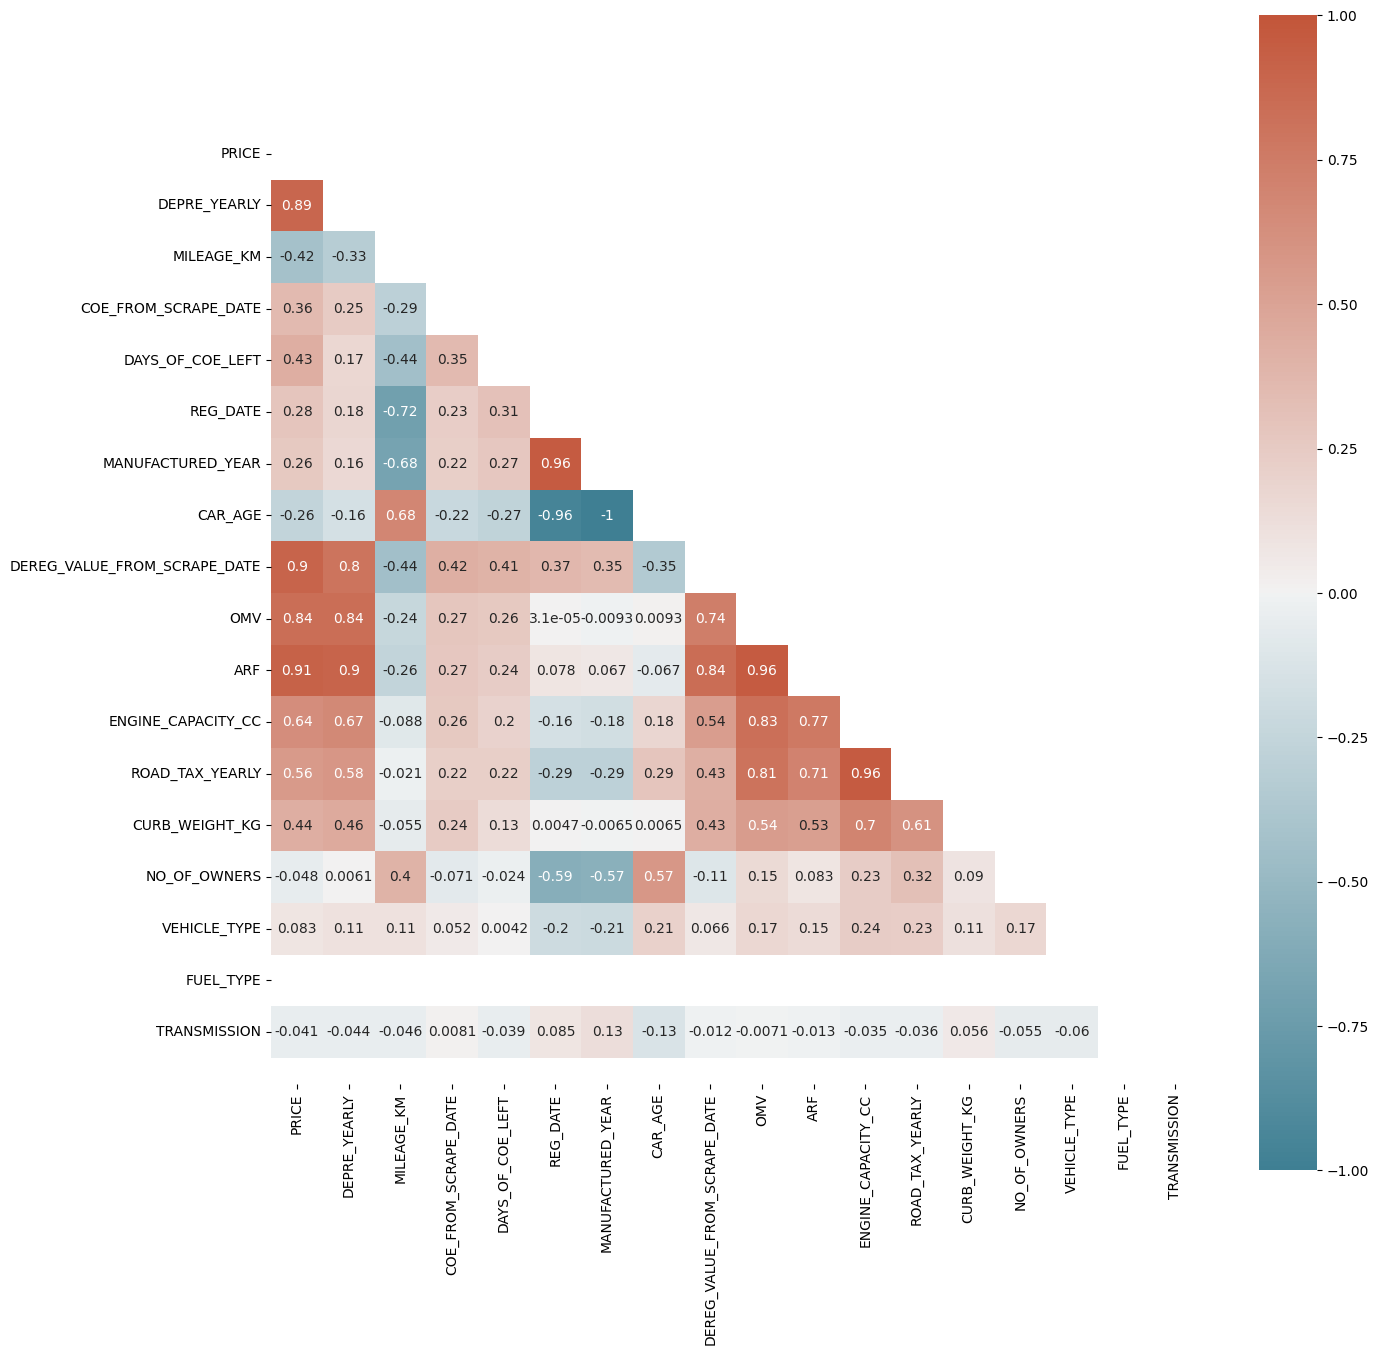

In [133]:
# Corr Matrix Heatmap Visualization

plot_corr_matrix_heatmap(df_price_no_brands)

#### From the above Corr Matrix, we can observe that a few Independent Variables are highly correlated with each other. 
Interestingly, this makes sense due to how a few of the independent variables are calculated. Therefore, some of these features can be dropped.  
1. **OMV and ARF:** 
The Additional Registration Fee (ARF) is a tax imposed upon registration of a vehicle. It is calculated based on a percentage of the Open Market Value (OMV) of the vehicle. From the correlation matrix, they have a correlation of **0.96.** Therefore, we can just keep one of this. Therefore, **ARF** will be dropped.
   
   
2. **Engine CC and Road Tax:** 
Road tax increases as engine CC increases. Therefore, having Road Tax in it would be introducing multicolinearity into the model, since both explain the same thing anyway. From the correlation matrix, they have a correlation of **0.96**. Therefore, **road tax** column will be dropped.
   
   
3. **Manufactured Year and Car Age:** 
Obviously, manufactured year can be dropped, since Car Age is derived from year of manufacture. And since car age is more intuitive, **Manufactured Year** column will be dropped.  From the correlation matrix, they have a correlation of **-1**. 
  

  
4. **Dereg Value:**  
The deregistration value of a vehicle is amount one will get back from the government upon deregistering the vehicle for use in Singapore. It is the sum of the COE rebate and the PARF rebate.
The COE rebate is a percentage of the original COE value.
The PARF rebate is a percentage of the original ARF.
Therefore, the **dereg value will be dropped**. From the corr matrix, ARF and dereg value have a correlation of **0.75.**
  
  
5. **Depreciation:** 
Annual depreciation is the amount the owner loses on the value of the vehicle per year based on the assumption that the vehicle is deregistered only at the end of its 10-yr COE life-span. The value of the car body has not been taken into account.  The formula used to derive the figure is as follows:  
Depreciation = (List Price - Minimum PARF value) ÷ remaining years of COE  
The minimum Preferential Additional Registration Fee (PARF) value is a sum of money that the vehicle owner gets for deregistering his vehicle at the end of its 10-yr COE. It is a function of the Open Market Value (OMV) or Additional Registration Fee (ARF). Commercial vehicles and cars with renewed COE have no minimum PARF value.  Depreciation and ARF have a correlation of **0.88**. **Depreciation** will be dropped.


### Section 3.1.2: Removing Independent Variables with High Correlation to each other

In [134]:
df_price_no_brands = df_price_no_brands.drop(['DEPRE_YEARLY', 'REG_DATE', 'MANUFACTURED_YEAR', 'DEREG_VALUE_FROM_SCRAPE_DATE', 'OMV', 'ROAD_TAX_YEARLY', 'VEHICLE_TYPE', 'FUEL_TYPE'], axis=1)
df_price_no_brands.columns

Index(['PRICE', 'MILEAGE_KM', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'ARF', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'],
      dtype='object')

### Section 3.1.3: Re-Visualizing New Correlation Matrix (with a few features dropped)

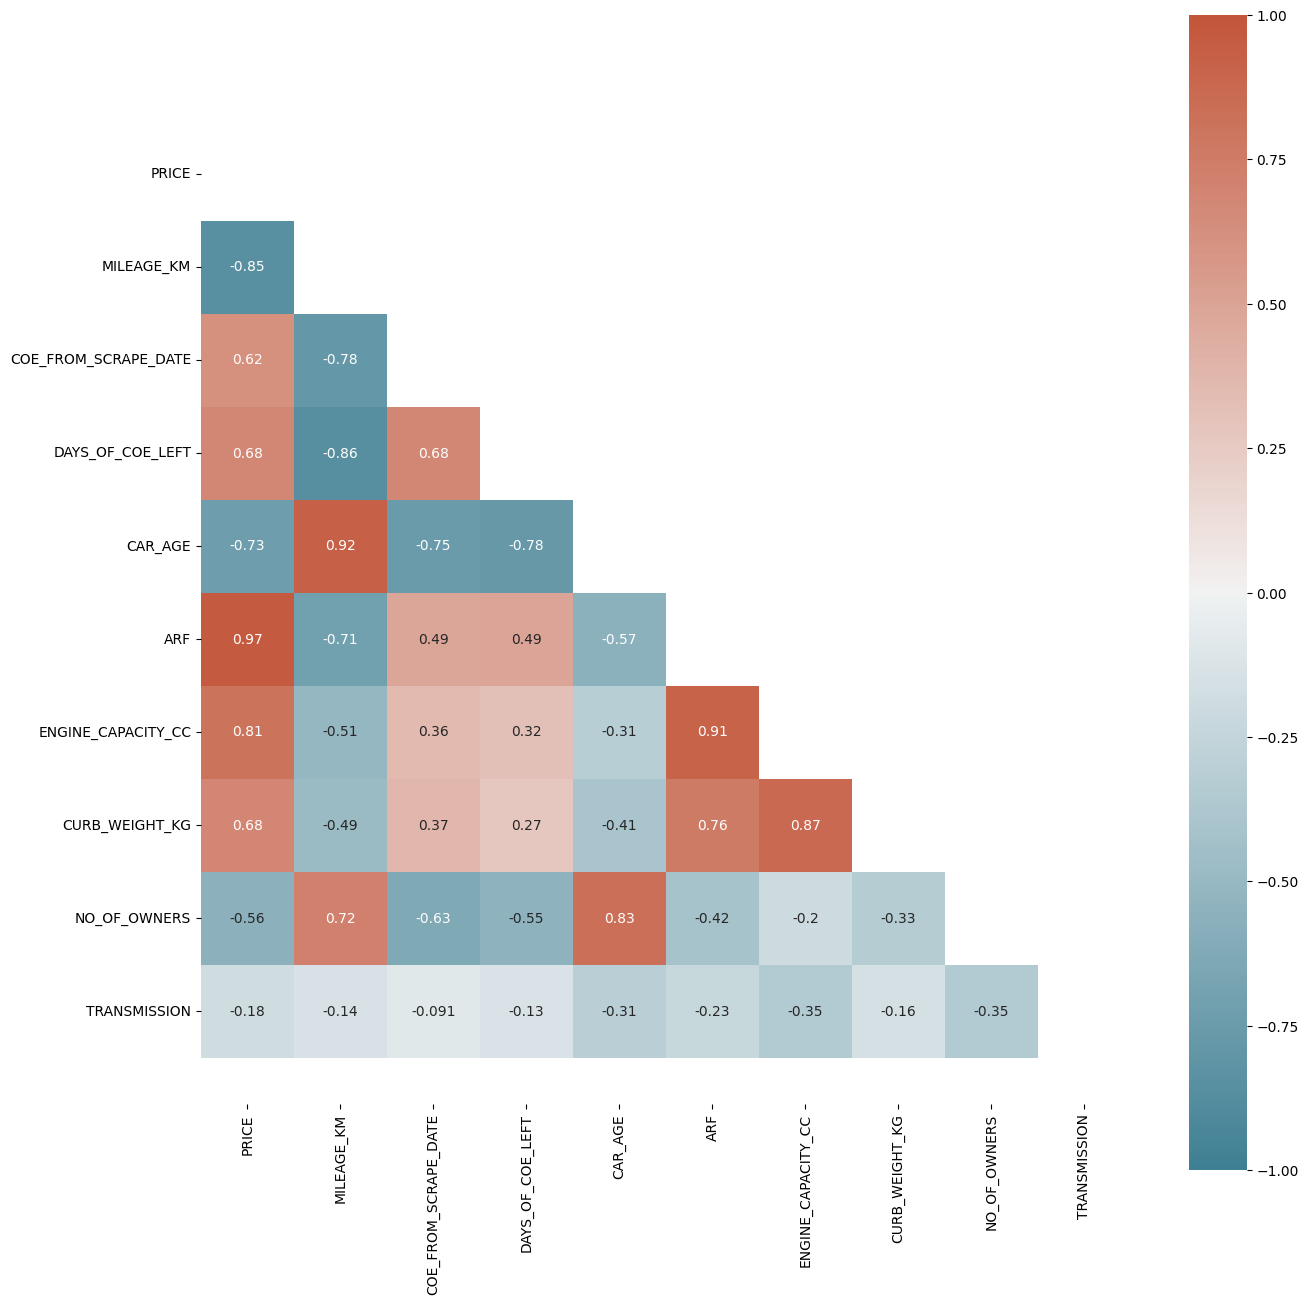

In [135]:
# Re-visualizing the correlation matrix

# Creating the data
data = df_price_no_brands.corr()

plot_corr_matrix_heatmap(data)

In [136]:
# Correlations of the independent variables (features) to dependent variable (target, price)
df_price_no_brands.corr()['PRICE'].sort_values(ascending=False)

PRICE                   1.000000
ARF                     0.914575
ENGINE_CAPACITY_CC      0.635167
CURB_WEIGHT_KG          0.435017
DAYS_OF_COE_LEFT        0.432567
COE_FROM_SCRAPE_DATE    0.356902
TRANSMISSION           -0.040888
NO_OF_OWNERS           -0.047907
CAR_AGE                -0.258735
MILEAGE_KM             -0.421938
Name: PRICE, dtype: float64

#### Section 3.1.3.1: Pairplot after Feature Selection

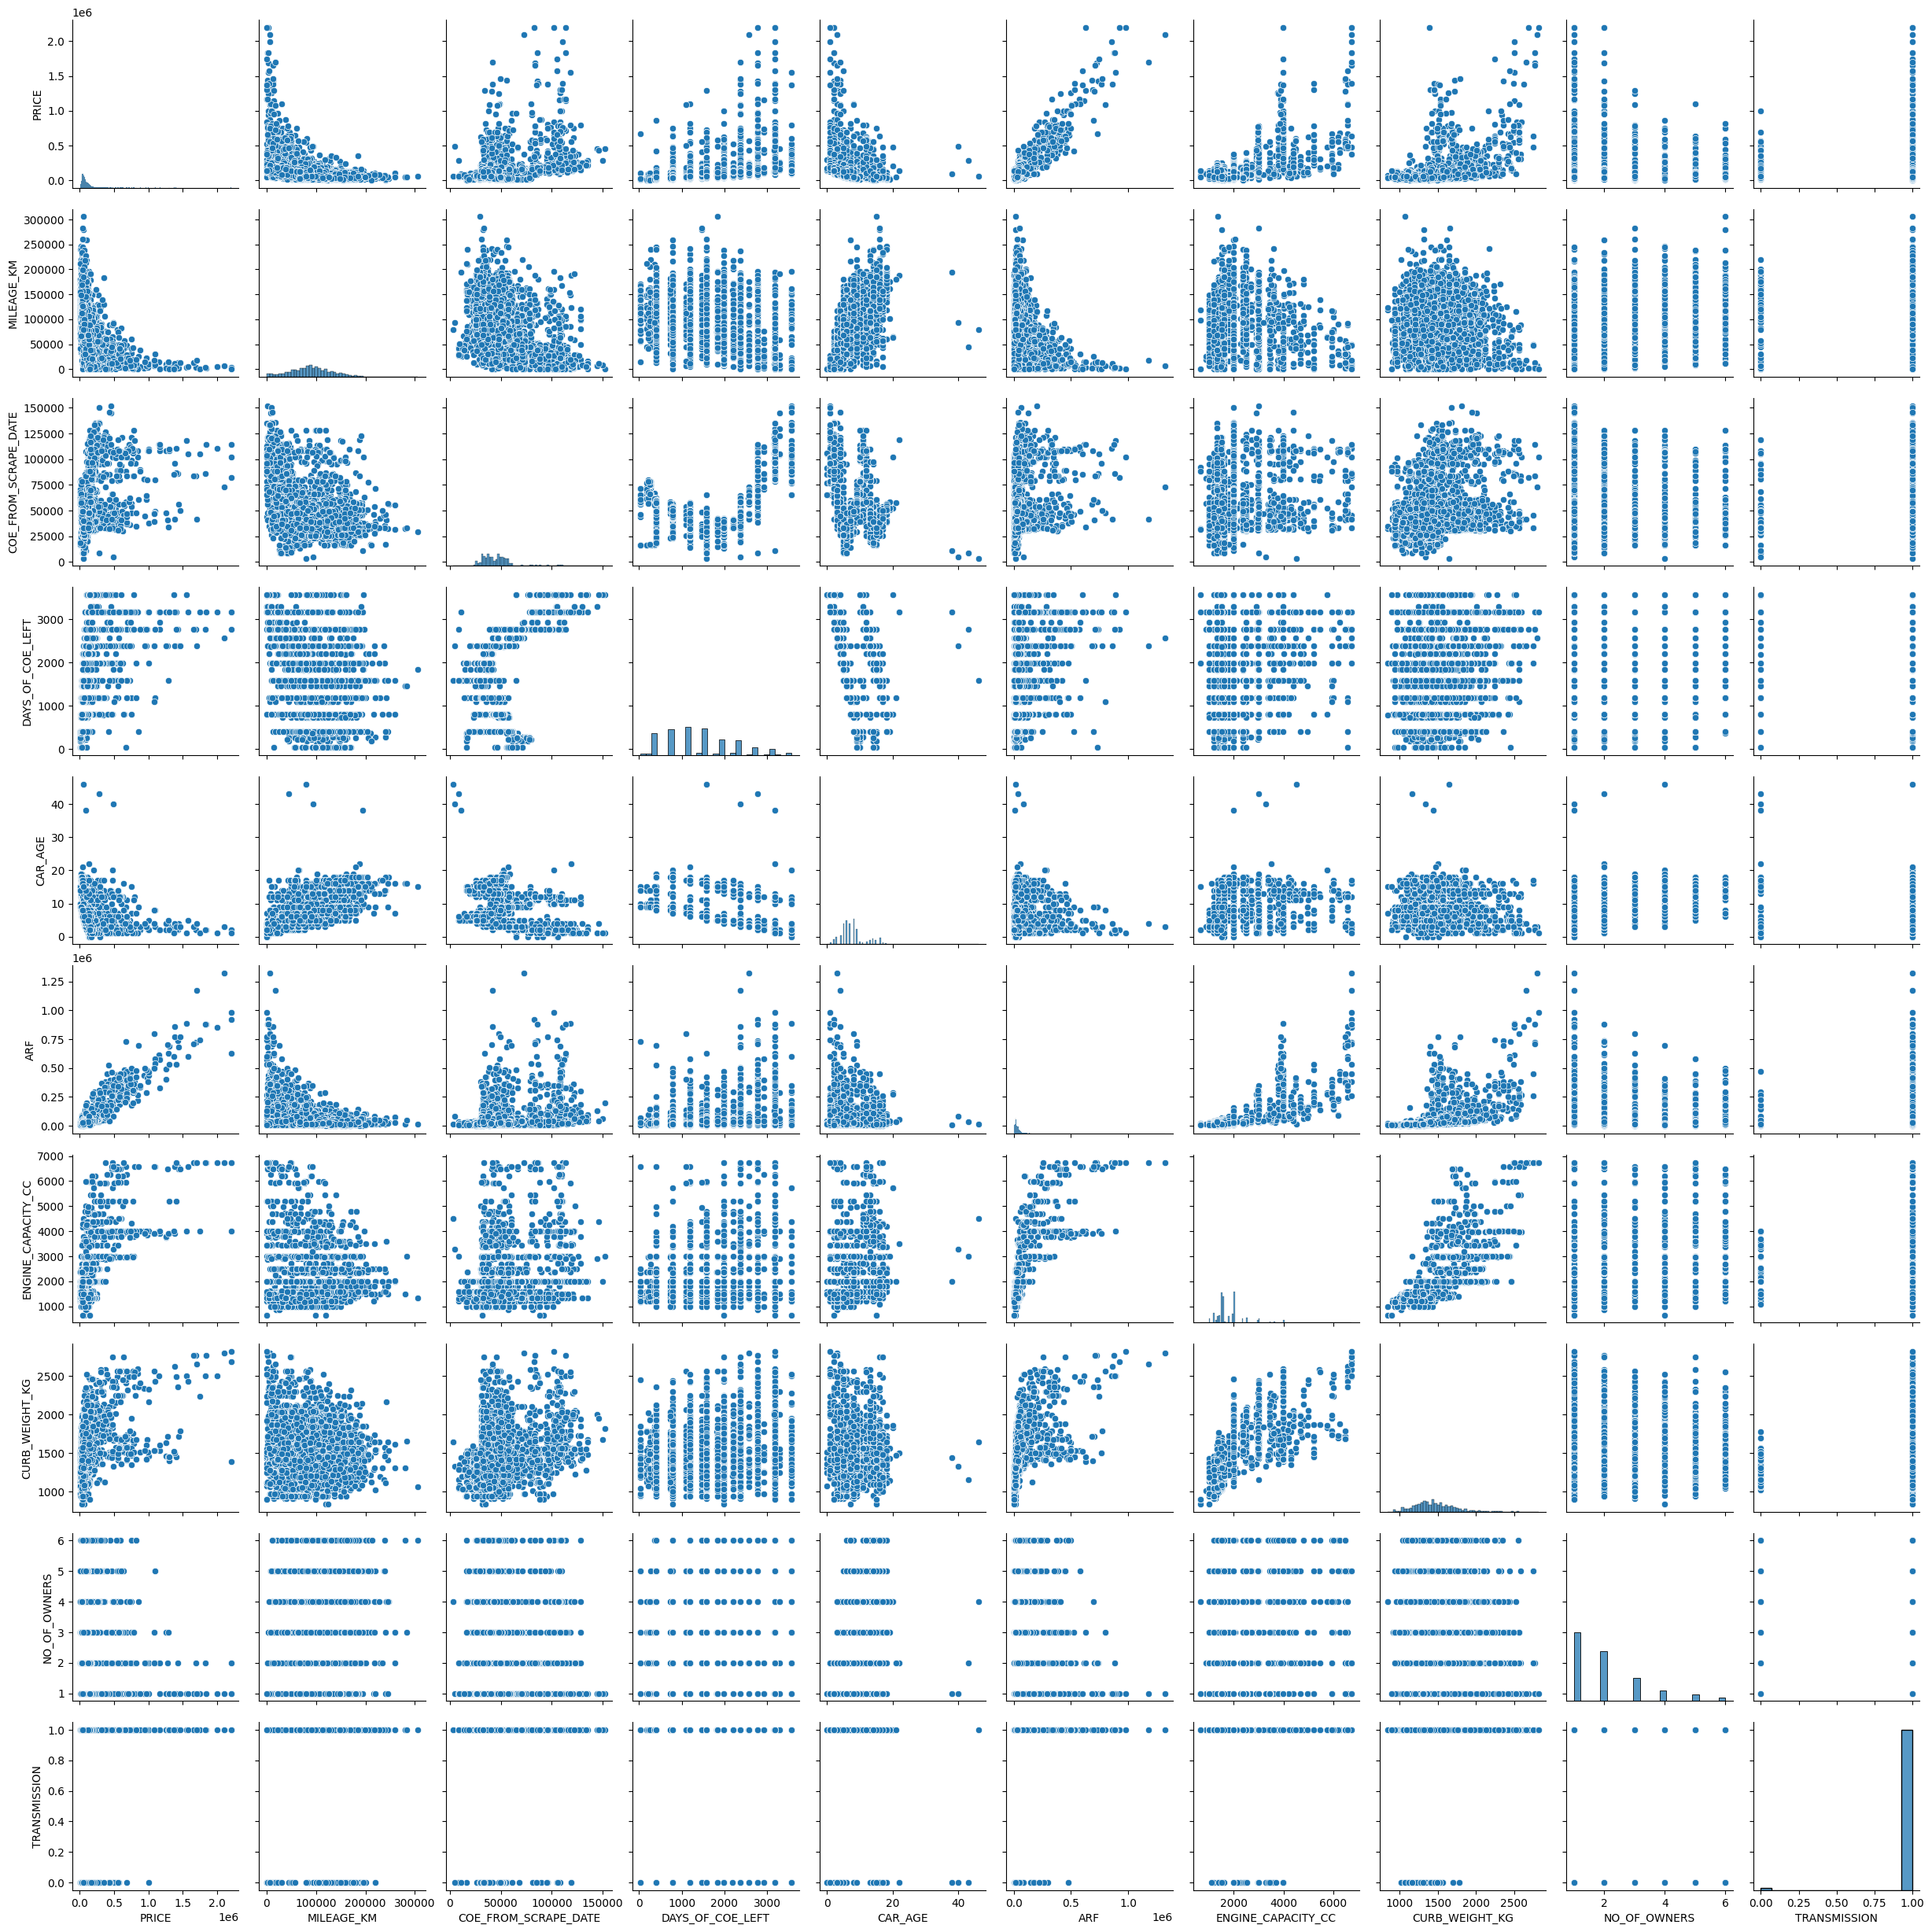

In [137]:
# Performing a pairplot to visualize the data trends of the variables

# We can see that price and mileage hold a negative linear relationship
# COE from the scrape date doesn't seem to have a very clear relatonship here
# Days of COE seems to have a slight linear r/s
# Car age doesn't seem to have a very distinct relationship here. But generally, the younger the car, the higher the price
# OMV has a clear increasing linear rs with price with price
# Engine capacity seems to also have a increasing linear r/s  with price, with a few outliers in the center
# Perhaps it's because a lot of the higher-priced cars (higher brands) are produced in that engine capacity range?
# Curb weight seems to have a linear r/s too.

sns.pairplot(df_price_no_brands);

In [138]:
df_price_no_brands.columns

Index(['PRICE', 'MILEAGE_KM', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'ARF', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'],
      dtype='object')

### Section 3.2: Preliminary Model fitting to check R^2 Value and P>|t| values of Price and the leftover Independent Variables

In [139]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_price_no_brands[ ['MILEAGE_KM', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'ARF', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
X = sm.add_constant(X)
Y = df_price_no_brands['PRICE'].astype(float)



In [140]:
X.head()

const  MILEAGE_KM  COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT  CAR_AGE  \
1    1.0    167000.0               56206.0             792.0      8.0   
3    1.0     83888.0               40714.0            2376.0     13.0   
4    1.0    130000.0               47889.0             396.0      8.0   
5    1.0    121900.0               54200.0             792.0      8.0   
6    1.0     83900.0               61103.0             396.0      9.0   

       ARF  ENGINE_CAPACITY_CC  CURB_WEIGHT_KG  NO_OF_OWNERS  TRANSMISSION  
1  38249.0              2261.0          1560.0           1.0           0.0  
3  48853.0              2979.0          1495.0           3.0           0.0  
4   7865.0              1496.0          1130.0           2.0           1.0  
5  27026.0              1395.0          1450.0           2.0           1.0  
6  21706.0              2498.0          1659.0           1.0           1.0

In [141]:
Y.head()

1     72000.0
3    193888.0
4     29088.0
5     45888.0
6     29800.0
Name: PRICE, dtype: float64

In [142]:
# model / fit / summarize
print(linear_regression_analysis(X, Y))

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     6974.
Date:                Sun, 15 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:07:41   Log-Likelihood:                -71345.
No. Observations:                5888   AIC:                         1.427e+05
Df Residuals:                    5878   BIC:                         1.428e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.076e+05 

In [143]:
print(random_forest_analysis(X, Y))

{'RMSE': 12176.14729271763, 'R^2': 0.9935228013592584}


### Section 3.2.1: Optimizing R^2 Value

#### Section 3.2.1.1: Checking Distributions & Pairplots of all Variables

##### Pairplot of Price vs Independent Variables (without any transformation)

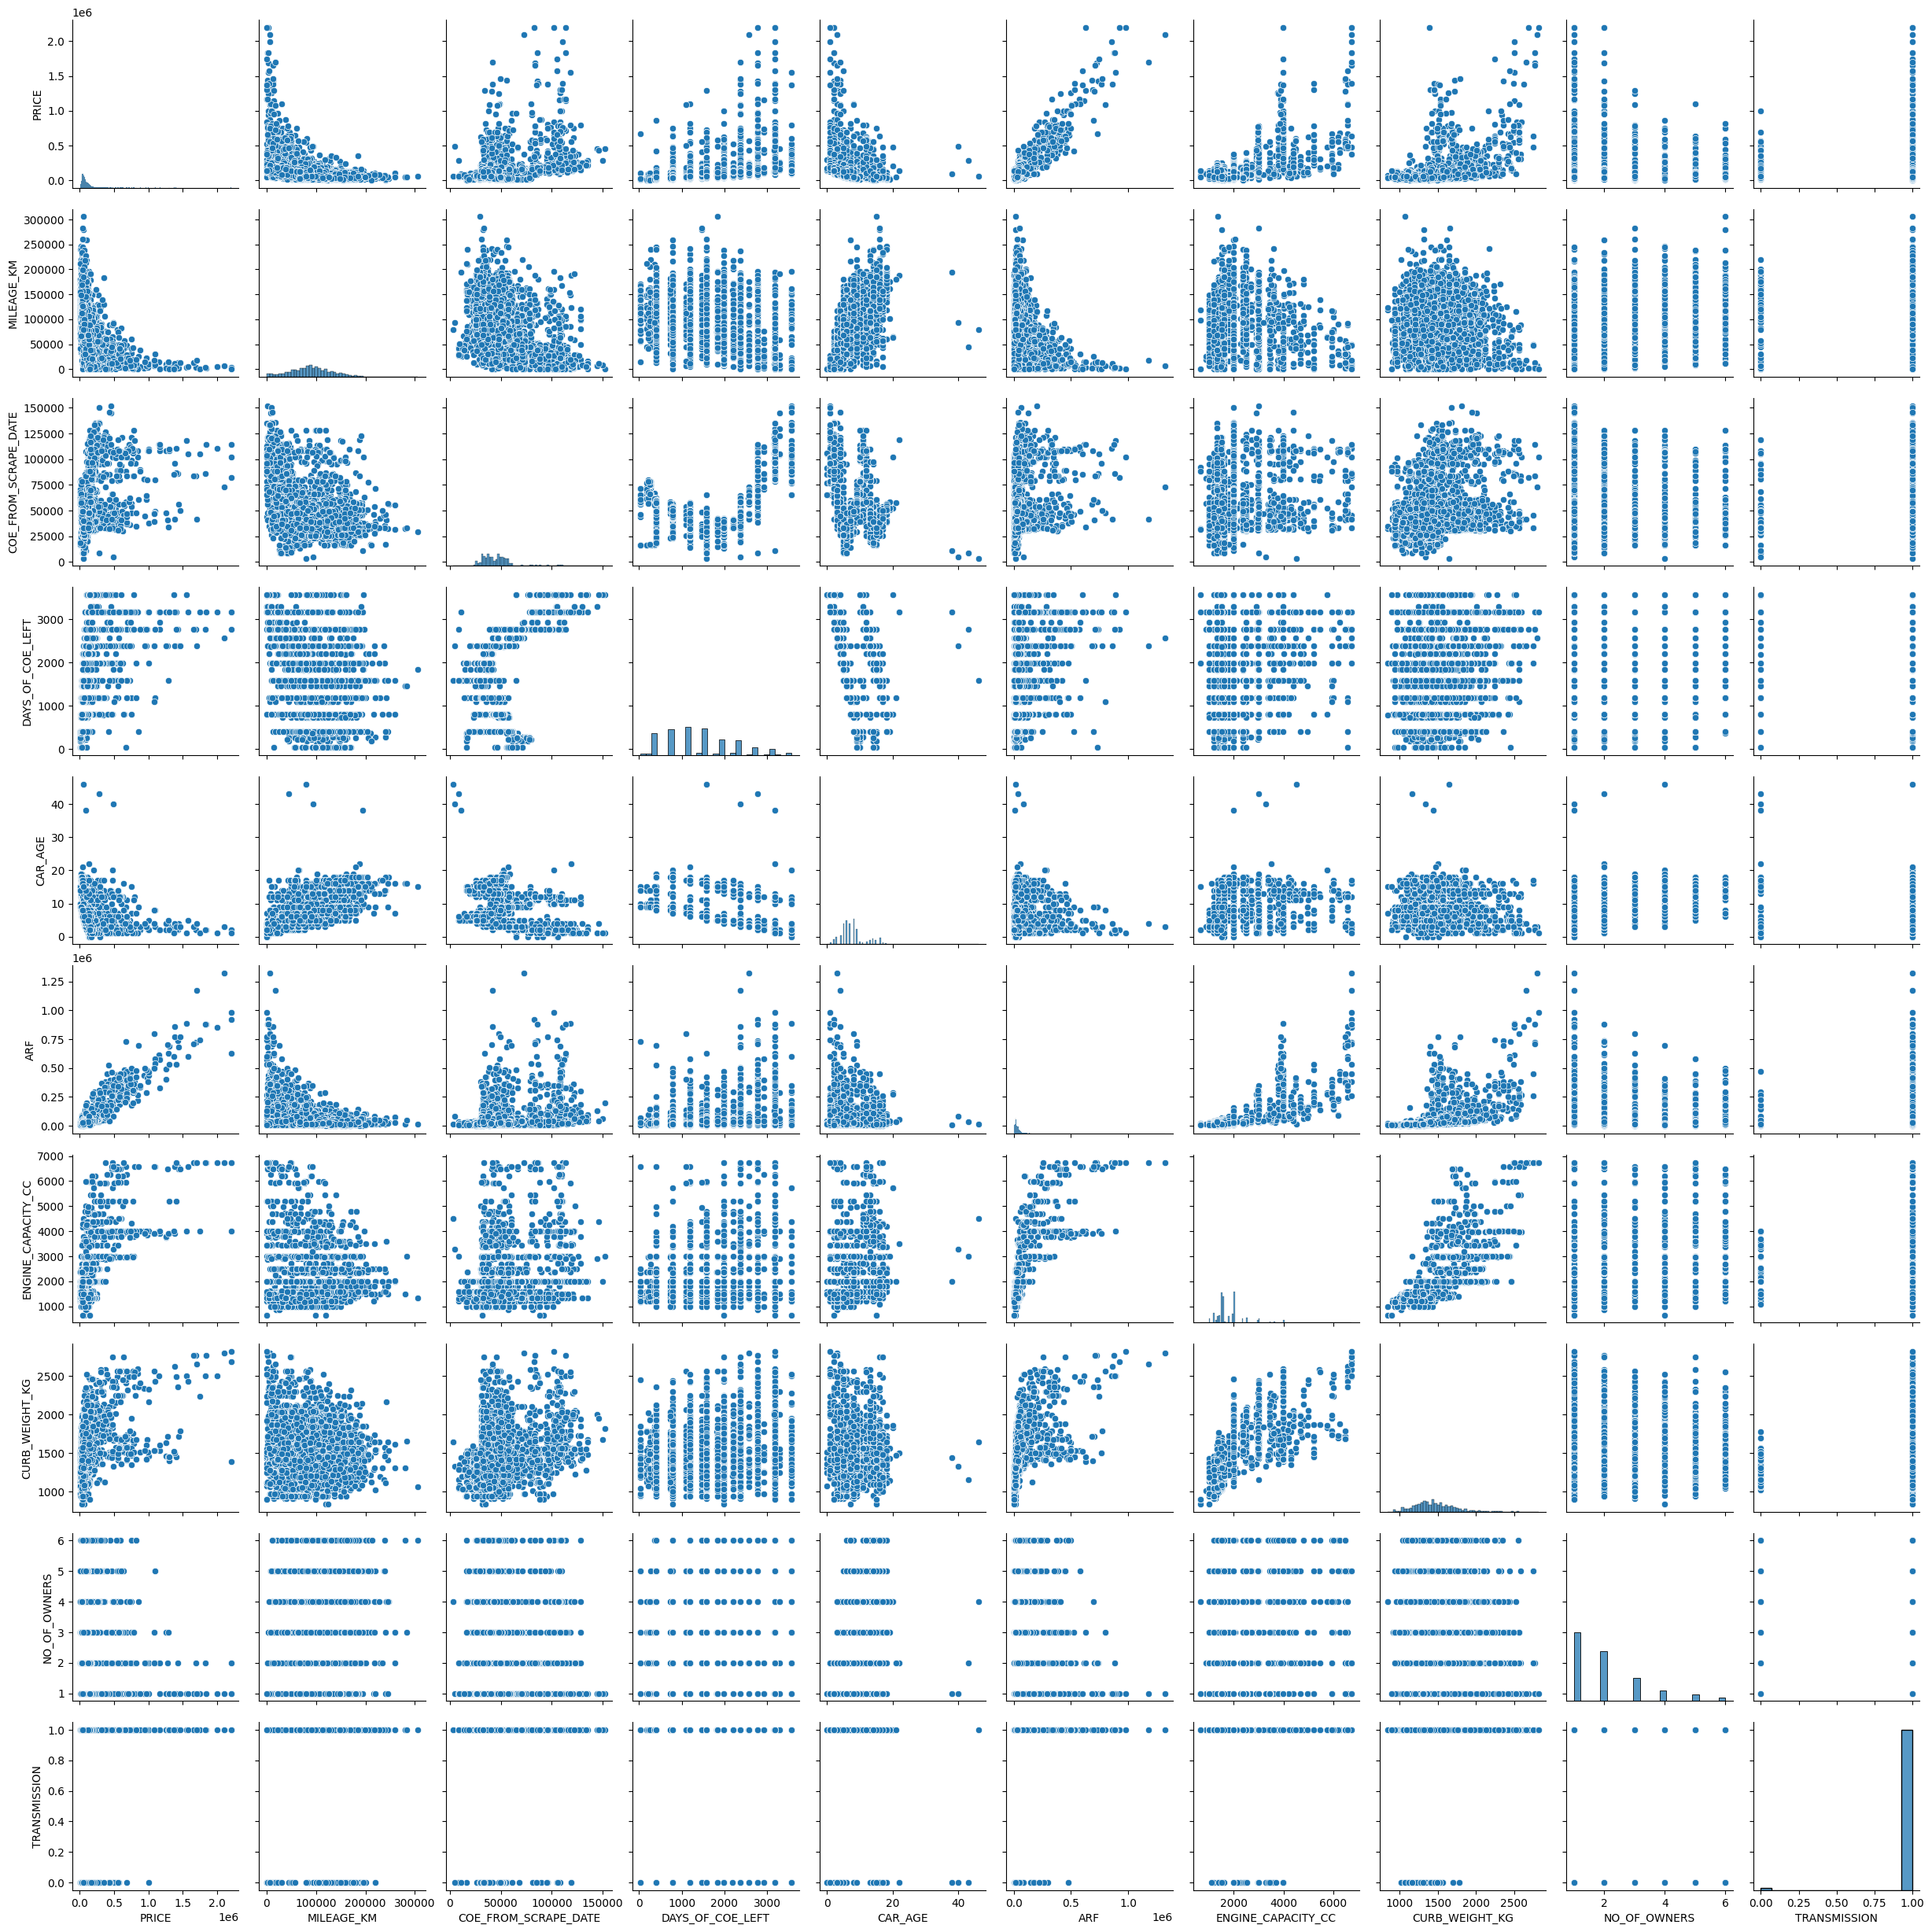

In [144]:
# Performing a pairplot to visualize the data trends of the variables

# We can see that price and mileage hold a negative linear relationship
# COE from the scrape date doesn't seem to have a very clear relatonship here
# Days of COE seems to have a slight linear r/s
# Car age doesn't seem to have a very distinct relationship here. But generally, the younger the car, the higher the price
# OMV has a clear increasing linear rs with price with price
# Engine capacity seems to also have a increasing linear r/s  with price, with a few outliers in the center
# Perhaps it's because a lot of the higher-priced cars (higher brands) are produced in that engine capacity range?
# Curb weight seems to have a linear r/s too.

sns.pairplot(df_price_no_brands);

##### Histograph of all Variables (Columns) in DataFrame

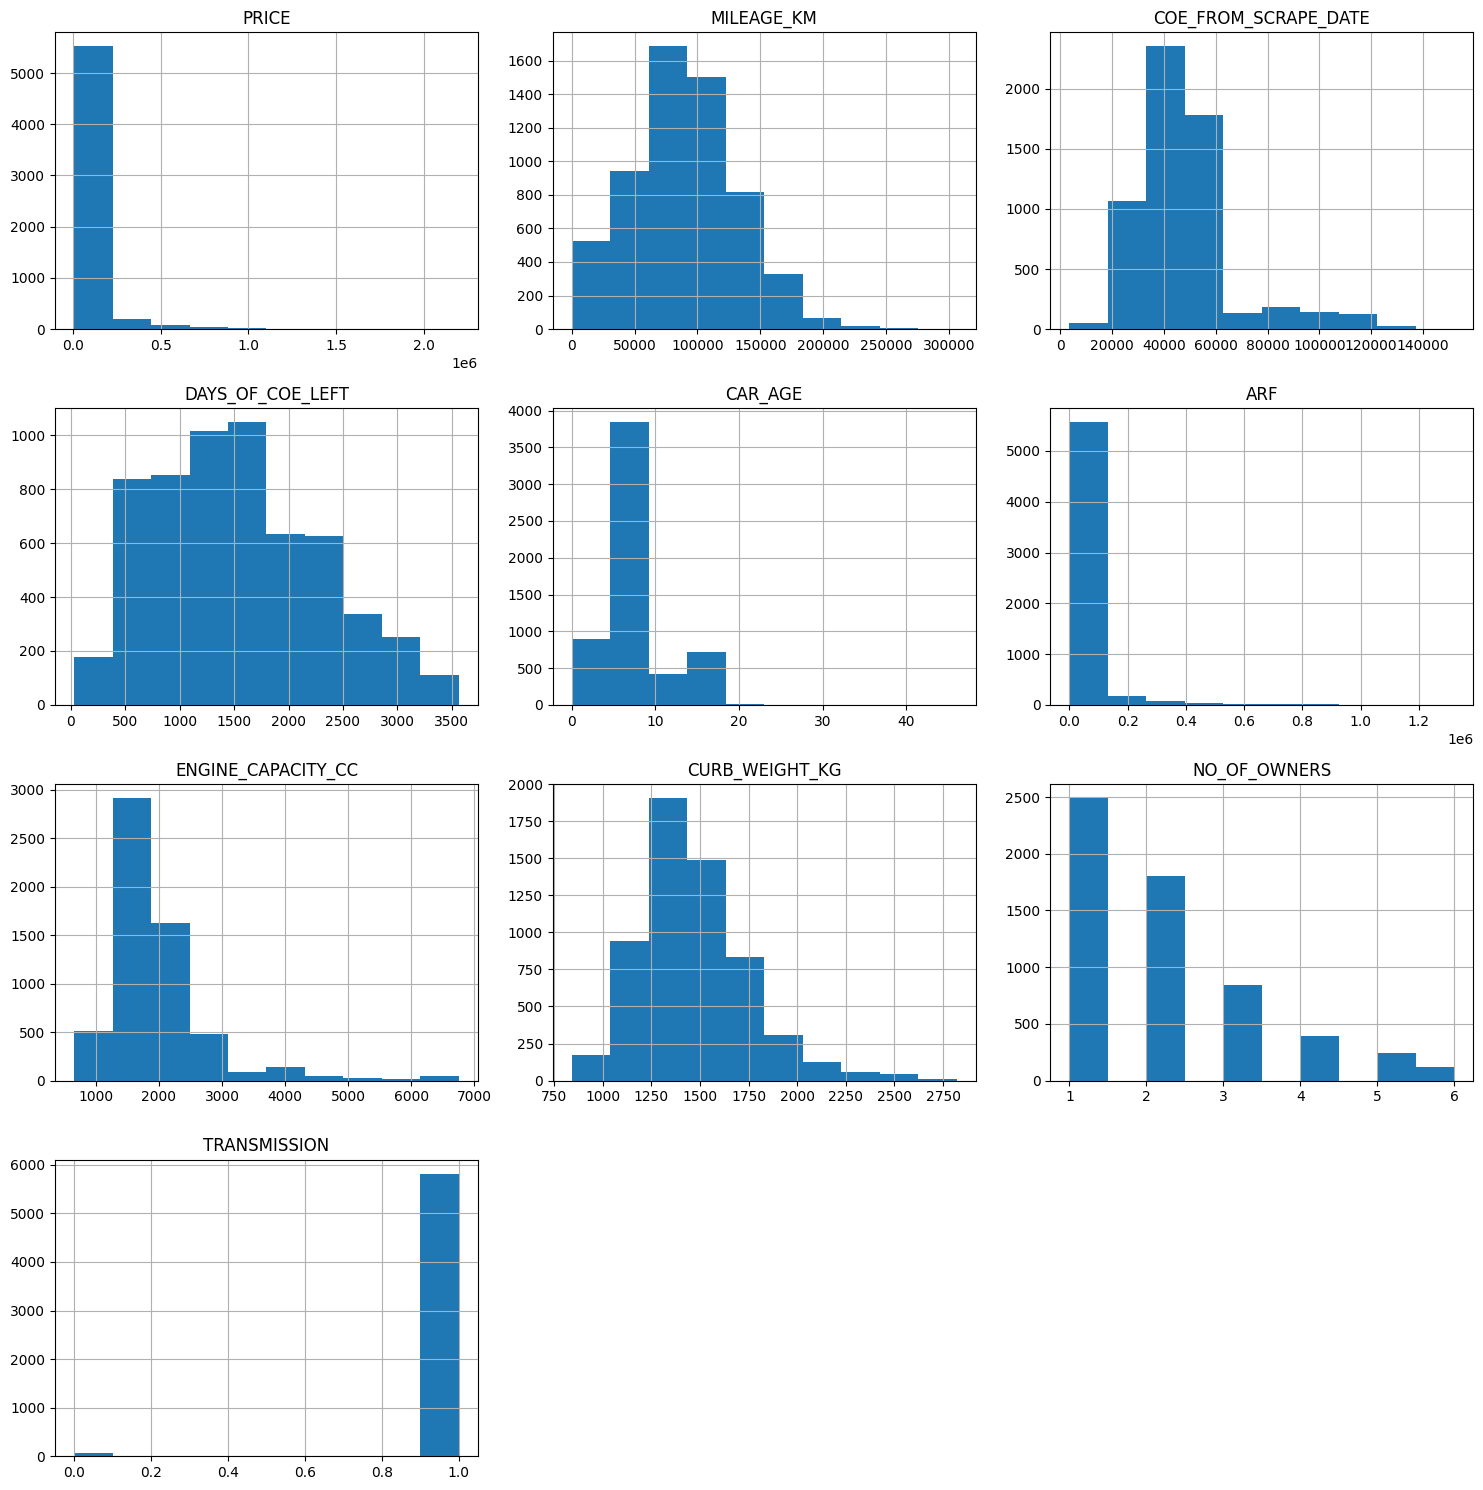

In [145]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(df_price_no_brands.columns):
    df_price_no_brands[col].hist(ax=axes[i])
    axes[i].set_title(col)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

From the above graphs, it would make sense to apply log transform on the following variables to make them
* more normally distributed
* Mileage
* Engine Cap
* Price
* OMV

## Distribution of Price

<Axes: ylabel='PRICE'>

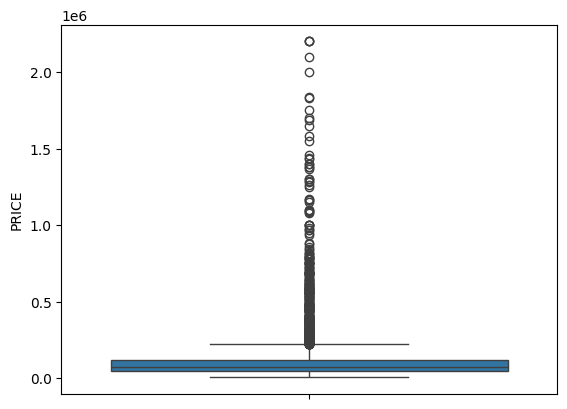

In [146]:
sns.boxplot(df_price_no_brands['PRICE'])  # 

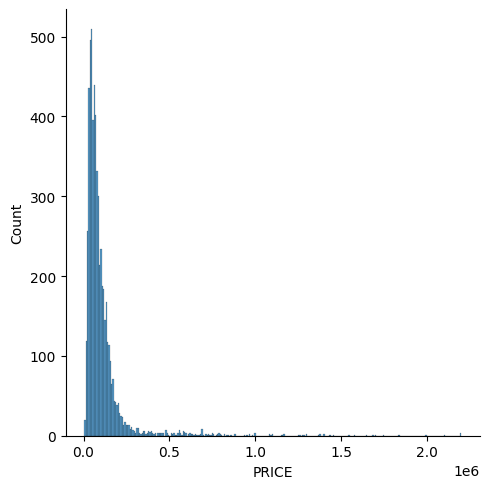

In [147]:
sns.displot(df_price_no_brands['PRICE'])  # Your dependent variable 'must' be normally distributed

We see that price is right-skewed. Therefore, we can try applying a log onto price, then visualize the data again.

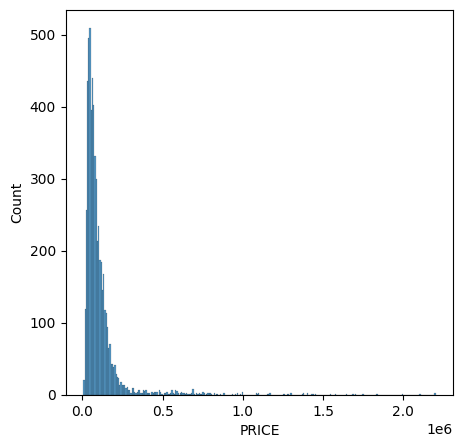

In [148]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(df_price_no_brands['PRICE'],ax=ax)
plt.xlabel('PRICE',size=10)
plt.savefig("price_no_log.png",transparent=True)

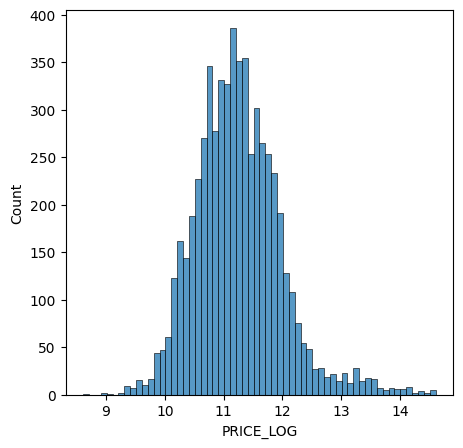

In [149]:
fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(np.log(df_price_no_brands['PRICE']),ax=ax)
plt.xlabel("PRICE_LOG",size=10)
plt.savefig("price_log.png",transparent=True)

### Section 3.2.1: Logging Mileage ONLY

In [150]:
# Creating a copy of the dataframe to work log on
df_price_no_brands_only_mileage_logged = df_price_no_brands.copy()

In [151]:
# Log Mileage
df_price_no_brands_only_mileage_logged["MILEAGE_LOG"] = df_price_no_brands_only_mileage_logged['MILEAGE_KM'].apply(np.log)
df_price_no_brands_only_mileage_logged

PRICE  MILEAGE_KM  COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT  CAR_AGE  \
1      72000.0    167000.0               56206.0             792.0      8.0   
3     193888.0     83888.0               40714.0            2376.0     13.0   
4      29088.0    130000.0               47889.0             396.0      8.0   
5      45888.0    121900.0               54200.0             792.0      8.0   
6      29800.0     83900.0               61103.0             396.0      9.0   
...        ...         ...                   ...               ...      ...   
9918   20800.0     66600.0               57301.0             396.0      9.0   
9919   35800.0    113000.0               49602.0             396.0      8.0   
9922   55288.0     80000.0               33207.0            1980.0     15.0   
9923  122888.0     67700.0               32889.0            2196.0      5.0   
9925   48800.0    126000.0               49602.0             396.0      8.0   

          ARF  ENGINE_CAPACITY_CC  CURB_WEIGHT_KG  NO_OF_OWNERS  TRANSMISSION  \
1     38249.0              2261.0          1560.0           1.0             0   
3     48853.0              2979.0          1495.0           3.0             0   
4      7865.0              1496.0          1130.0           2.0             1   
5     27026.0              1395.0          1450.0           2.0             1   
6     21706.0              2498.0          1659.0           1.0             1   
...       ...                 ...             ...           ...           ...   
9918  11687.0              1496.0          1321.0           1.0             1   
9919  23689.0              2360.0          1530.0           2.0             1   
9922  14916.0              1498.0          1310.0           1.0             0   
9923  33547.0              1332.0          1405.0           2.0             1   
9925  29225.0              1986.0          1570.0           1.0             1   

      MILEAGE_LOG  
1       12.025749  
3       11.337238  
4       11.775290  
5       11.710956  
6       11.337381  
...           ...  
9918    11.106460  
9919    11.635143  
9922    11.289782  
9923    11.122841  
9925    11.744037  

[5888 rows x 11 columns]

In [154]:
# Rearranging columns

df_price_no_brands_only_mileage_logged = \
df_price_no_brands_only_mileage_logged[['PRICE', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'ARF', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION']]

In [155]:
df_price_no_brands_only_mileage_logged.columns

Index(['PRICE', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'ARF', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'],
      dtype='object')

In [159]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_price_no_brands_only_mileage_logged[ ['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'ARF', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
Y = df_price_no_brands_only_mileage_logged['PRICE'].astype(float)


# model / fit / summarize
print(linear_regression_analysis(X, Y))

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     7216.
Date:                Sun, 15 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:03:35   Log-Likelihood:                -71253.
No. Observations:                5888   AIC:                         1.425e+05
Df Residuals:                    5878   BIC:                         1.426e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.415e+05 

In [160]:
print(random_forest_analysis(X, Y))

{'RMSE': 12195.235565021774, 'R^2': 0.9935024771235013}


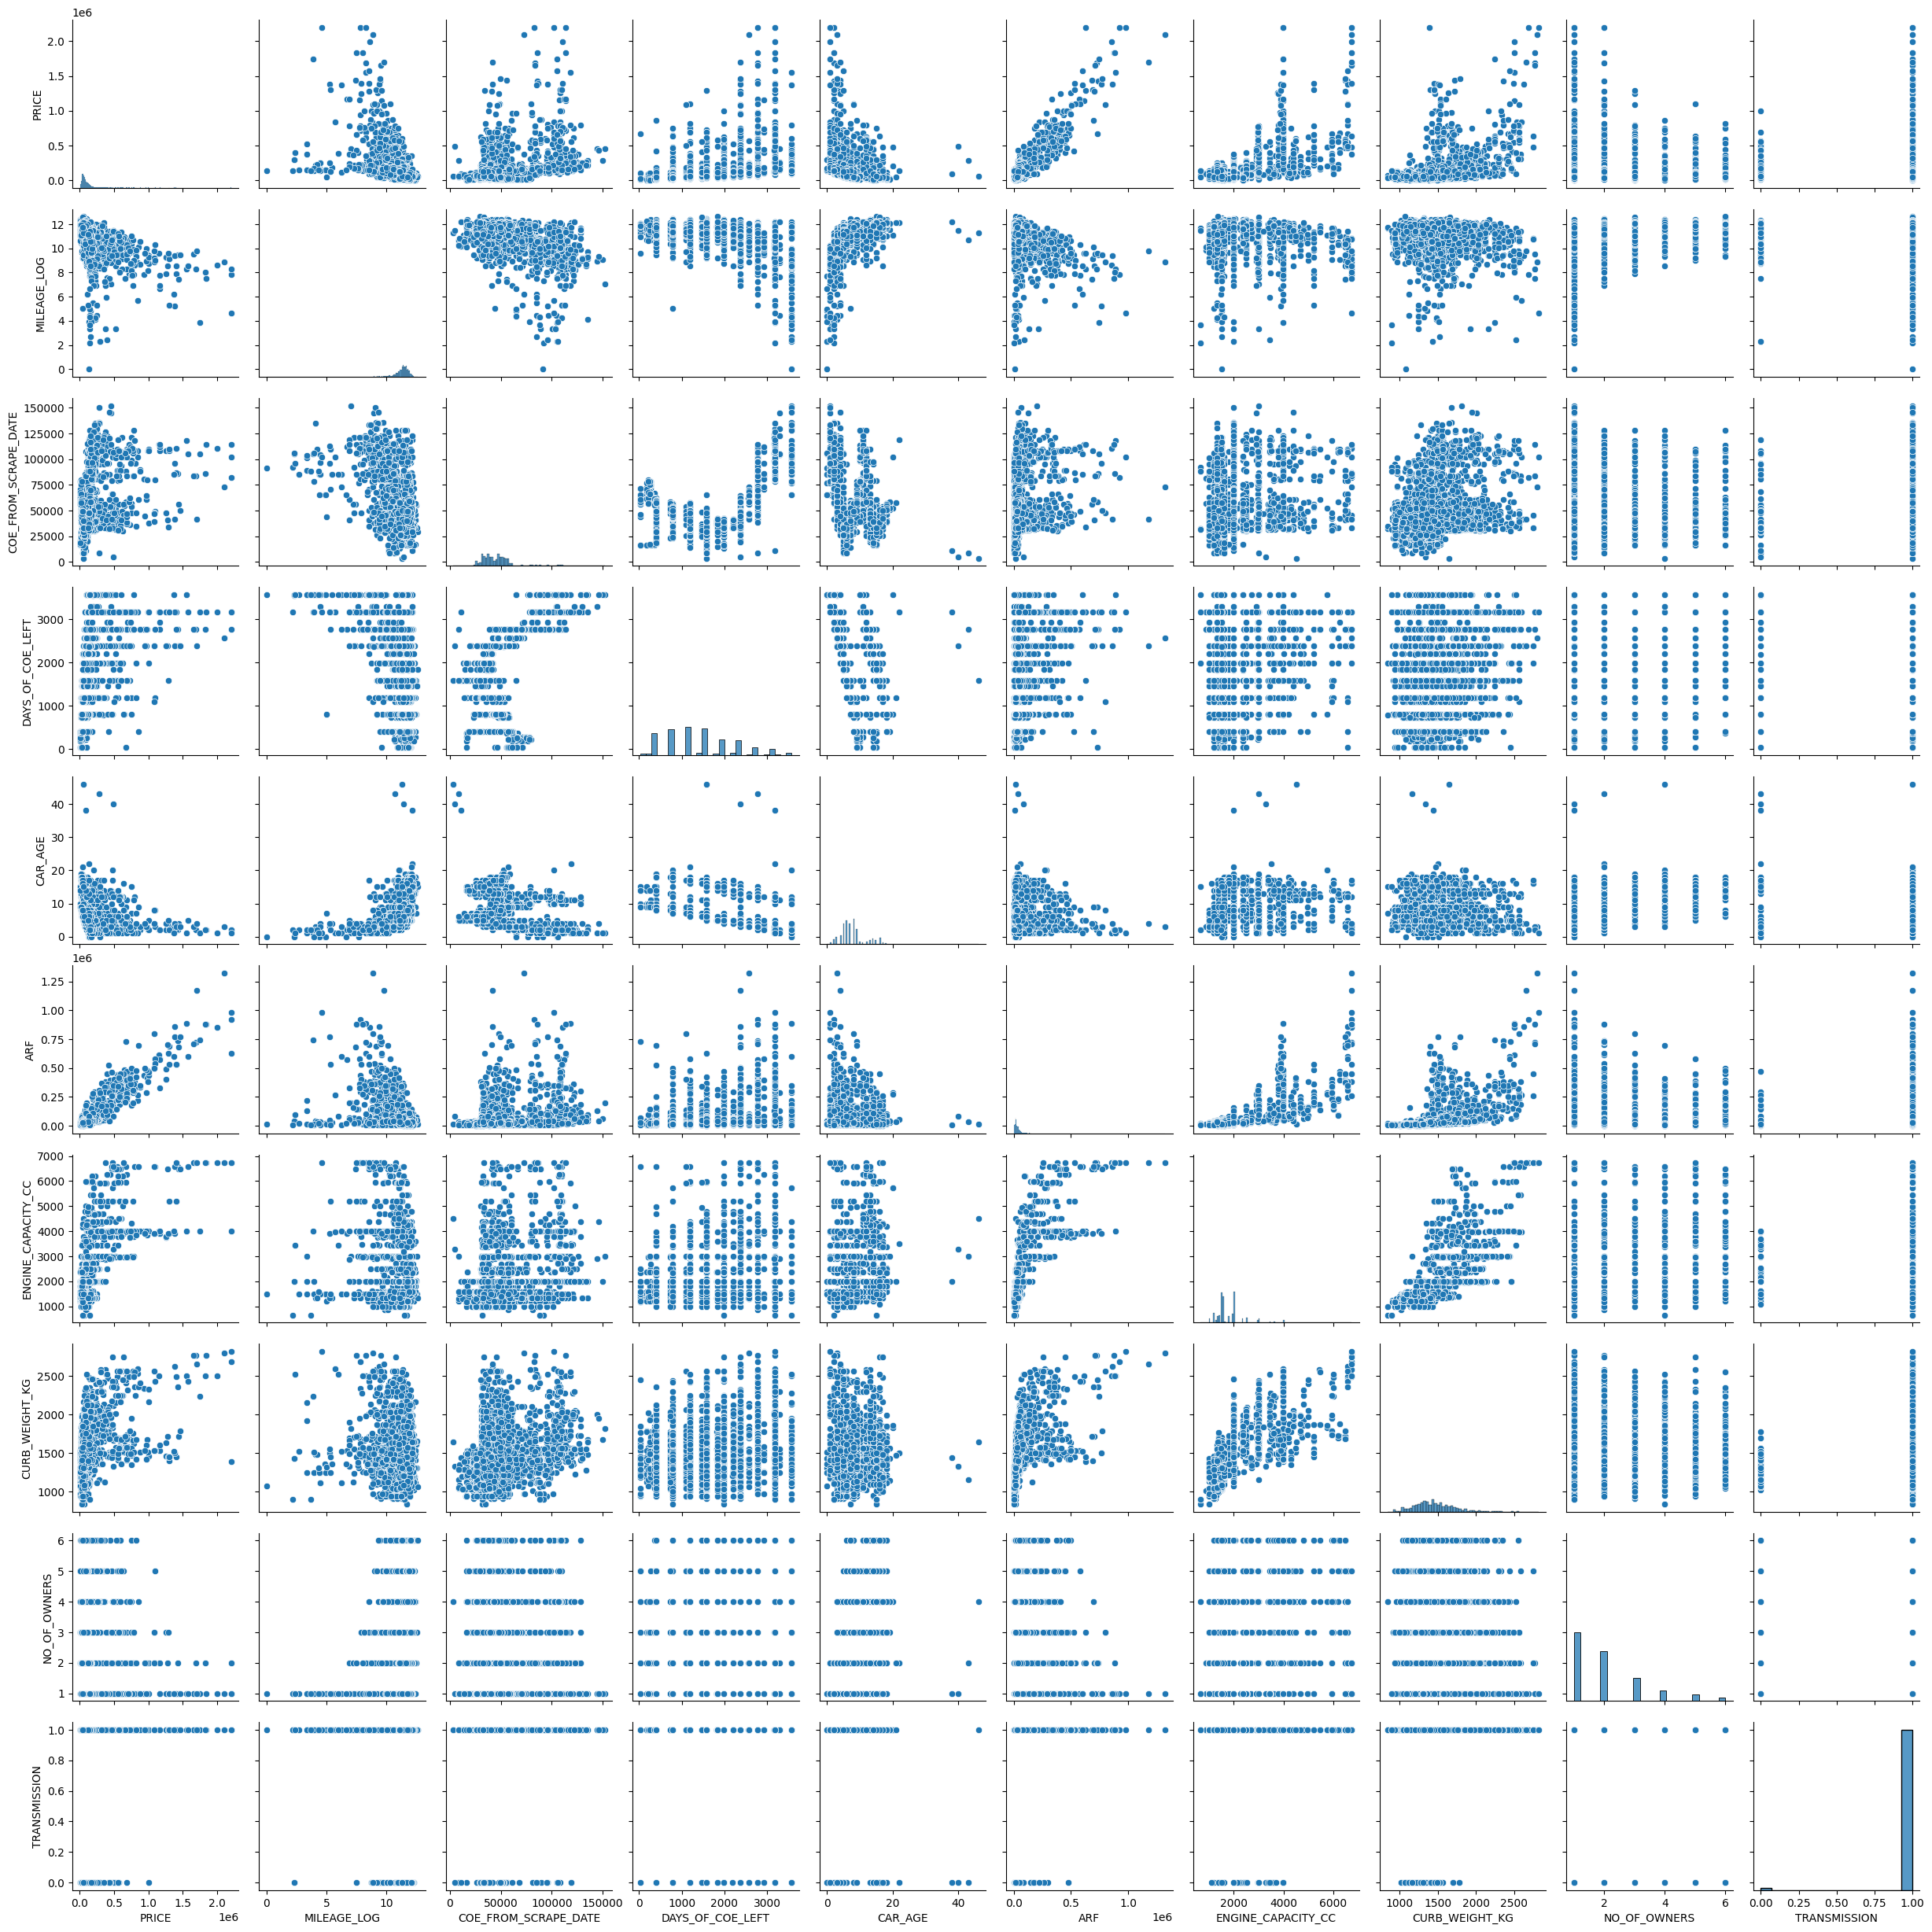

In [161]:
# Visualizing Pairplots of Price vs Other Features and Only Mileage logged

sns.pairplot(df_price_no_brands_only_mileage_logged);

### Section 3.2.2: Normal Price with Logged Mileage and Squared Engine CC

In [162]:
# Creating a copy of the dataframe to work log on
df_price_no_brands_mileage_logged_squared_engine_cap = df_price_no_brands_only_mileage_logged.copy()

In [163]:
# Square Engine CC
df_price_no_brands_mileage_logged_squared_engine_cap["ENGINE_SQUARED"] = \
df_price_no_brands_mileage_logged_squared_engine_cap['ENGINE_CAPACITY_CC'].apply(lambda x: x**2)

In [164]:
df_price_no_brands_mileage_logged_squared_engine_cap.columns

Index(['PRICE', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'ARF', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION', 'ENGINE_SQUARED'],
      dtype='object')

In [165]:
# Rearrange columns
df_price_no_brands_mileage_logged_squared_engine_cap = \
df_price_no_brands_mileage_logged_squared_engine_cap[['PRICE', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'ARF', 'ENGINE_SQUARED', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION']]

In [166]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_price_no_brands_mileage_logged_squared_engine_cap[ ['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'ARF', 'ENGINE_SQUARED', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
Y = df_price_no_brands_only_mileage_logged['PRICE'].astype(float)


# model / fit / summarize
print(linear_regression_analysis(X, Y))

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     7265.
Date:                Sun, 15 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:03:56   Log-Likelihood:                -71235.
No. Observations:                5888   AIC:                         1.425e+05
Df Residuals:                    5878   BIC:                         1.426e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.292e+05 

In [167]:
print(random_forest_analysis(X, Y))

{'RMSE': 12193.876031485639, 'R^2': 0.9935039257396953}


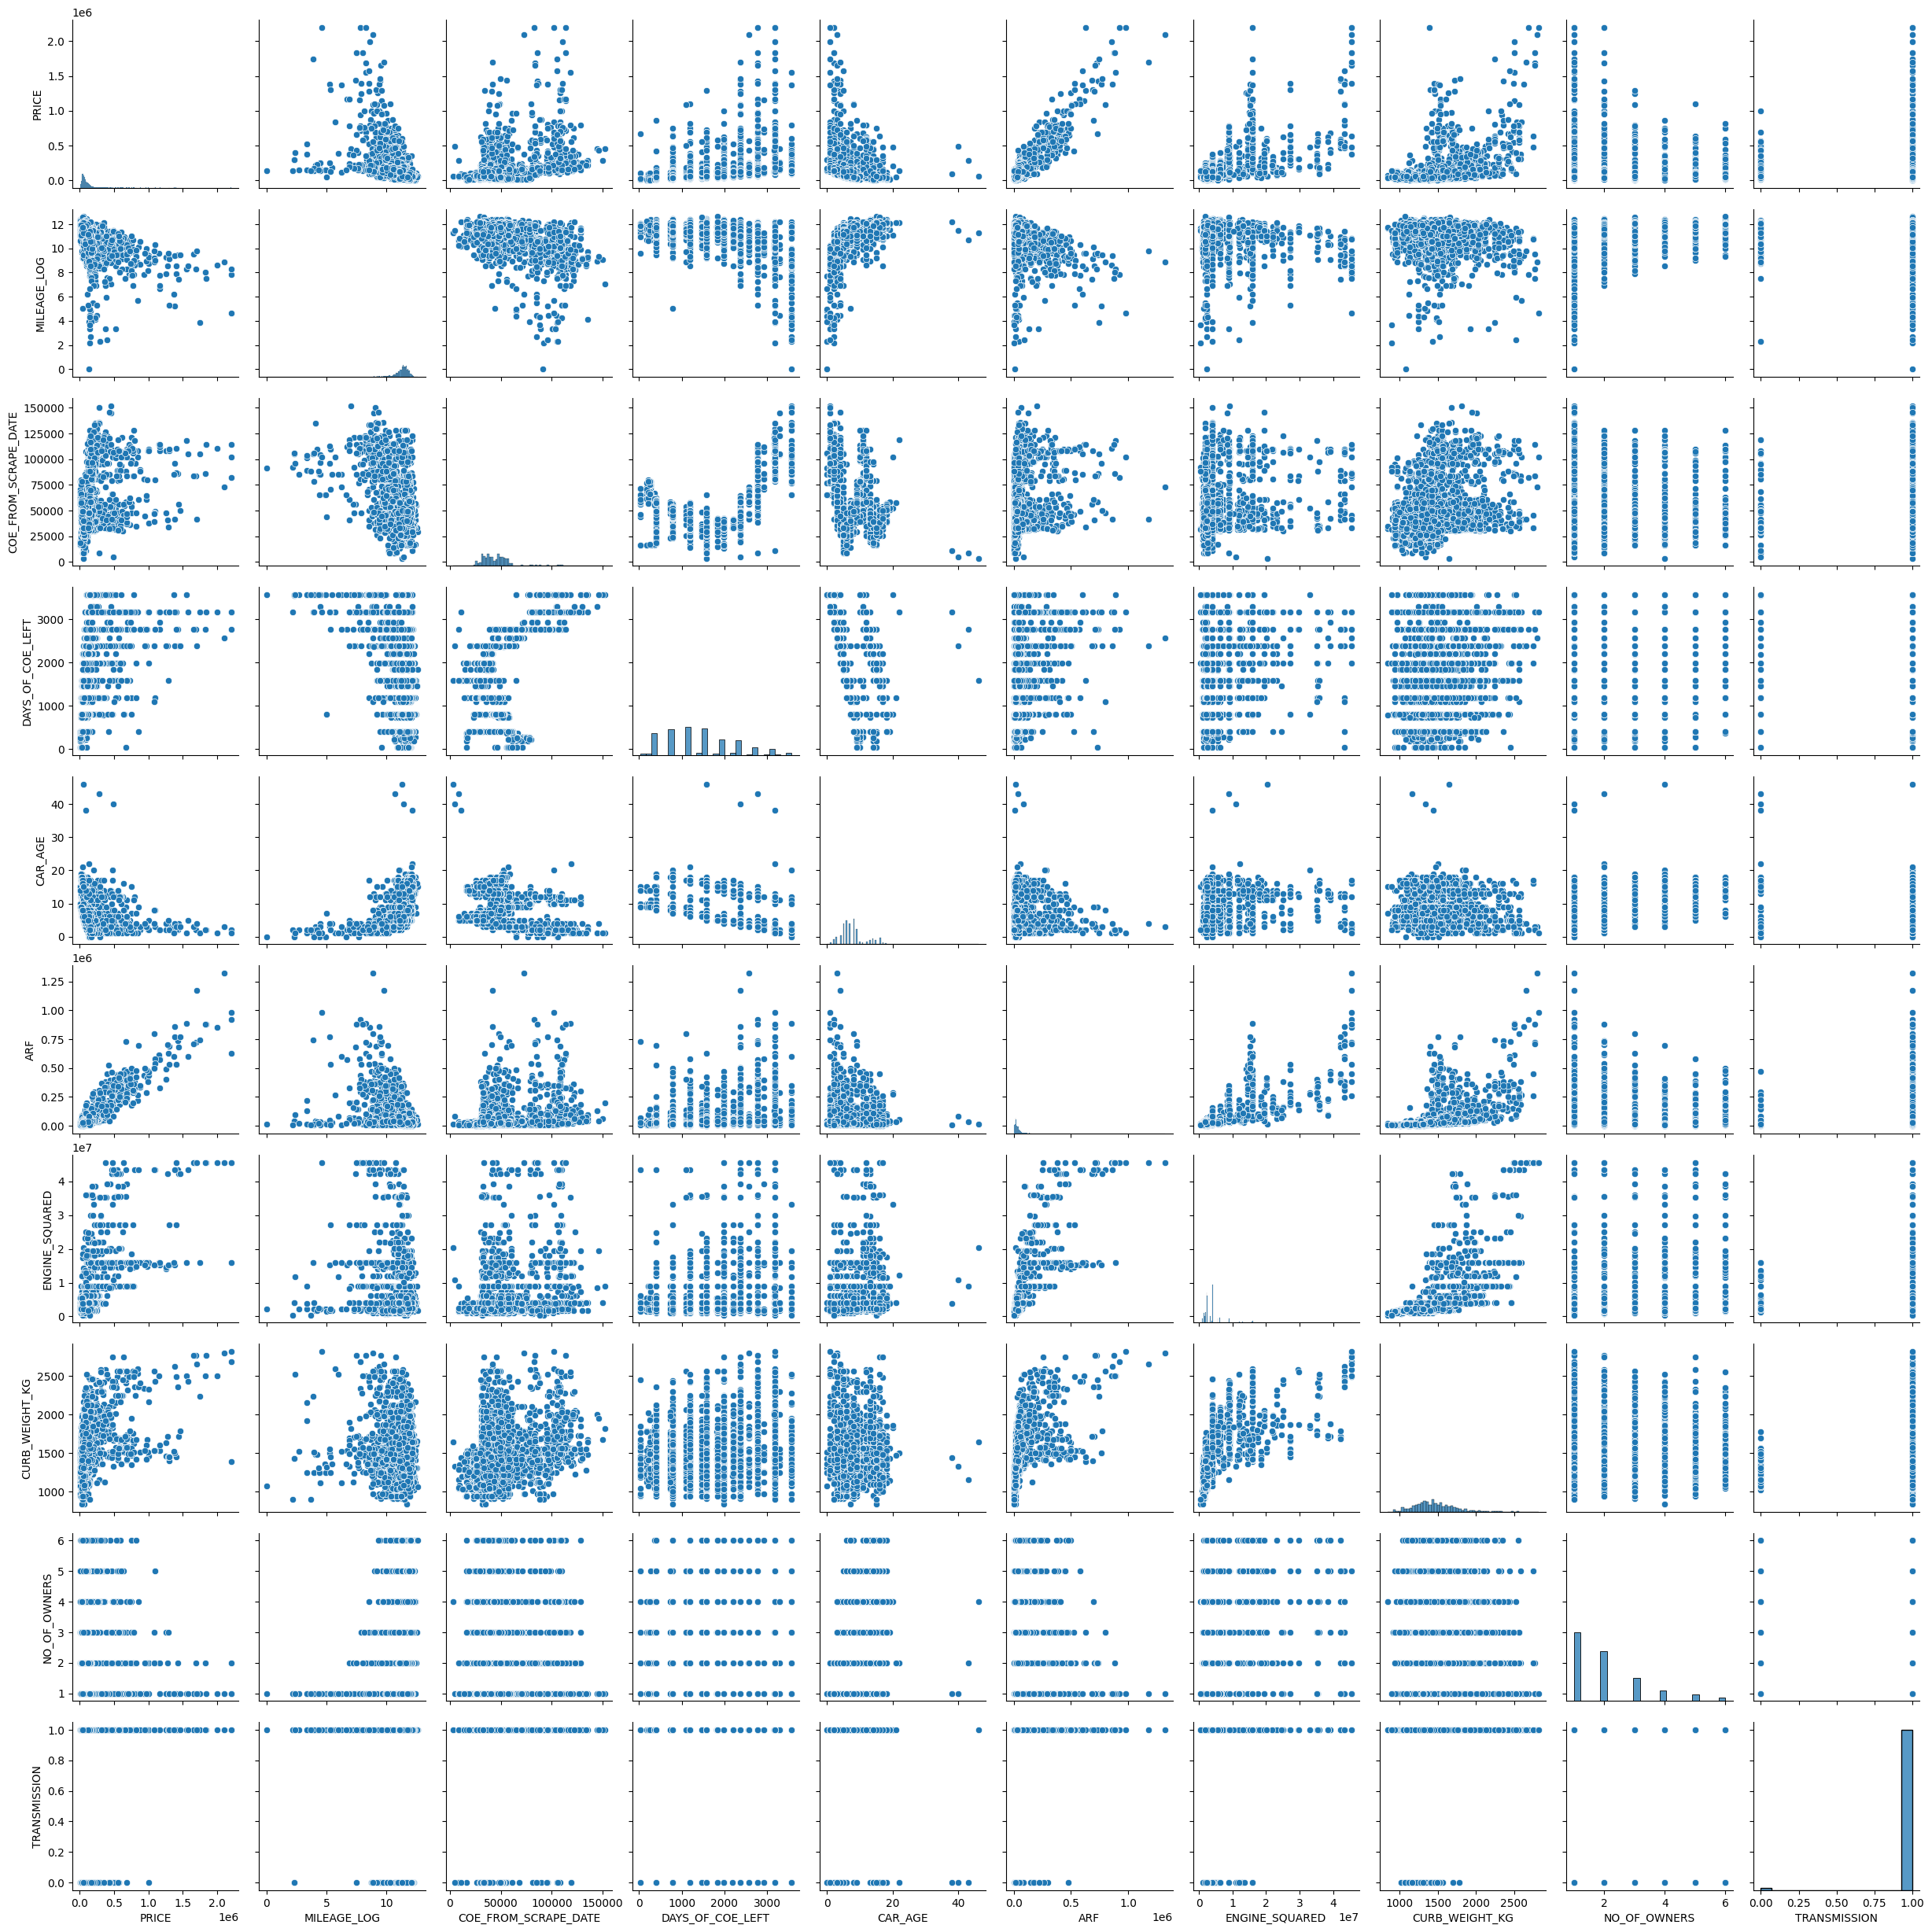

In [168]:
# Visualizing Pairplots of the distributions

sns.pairplot(df_price_no_brands_mileage_logged_squared_engine_cap);

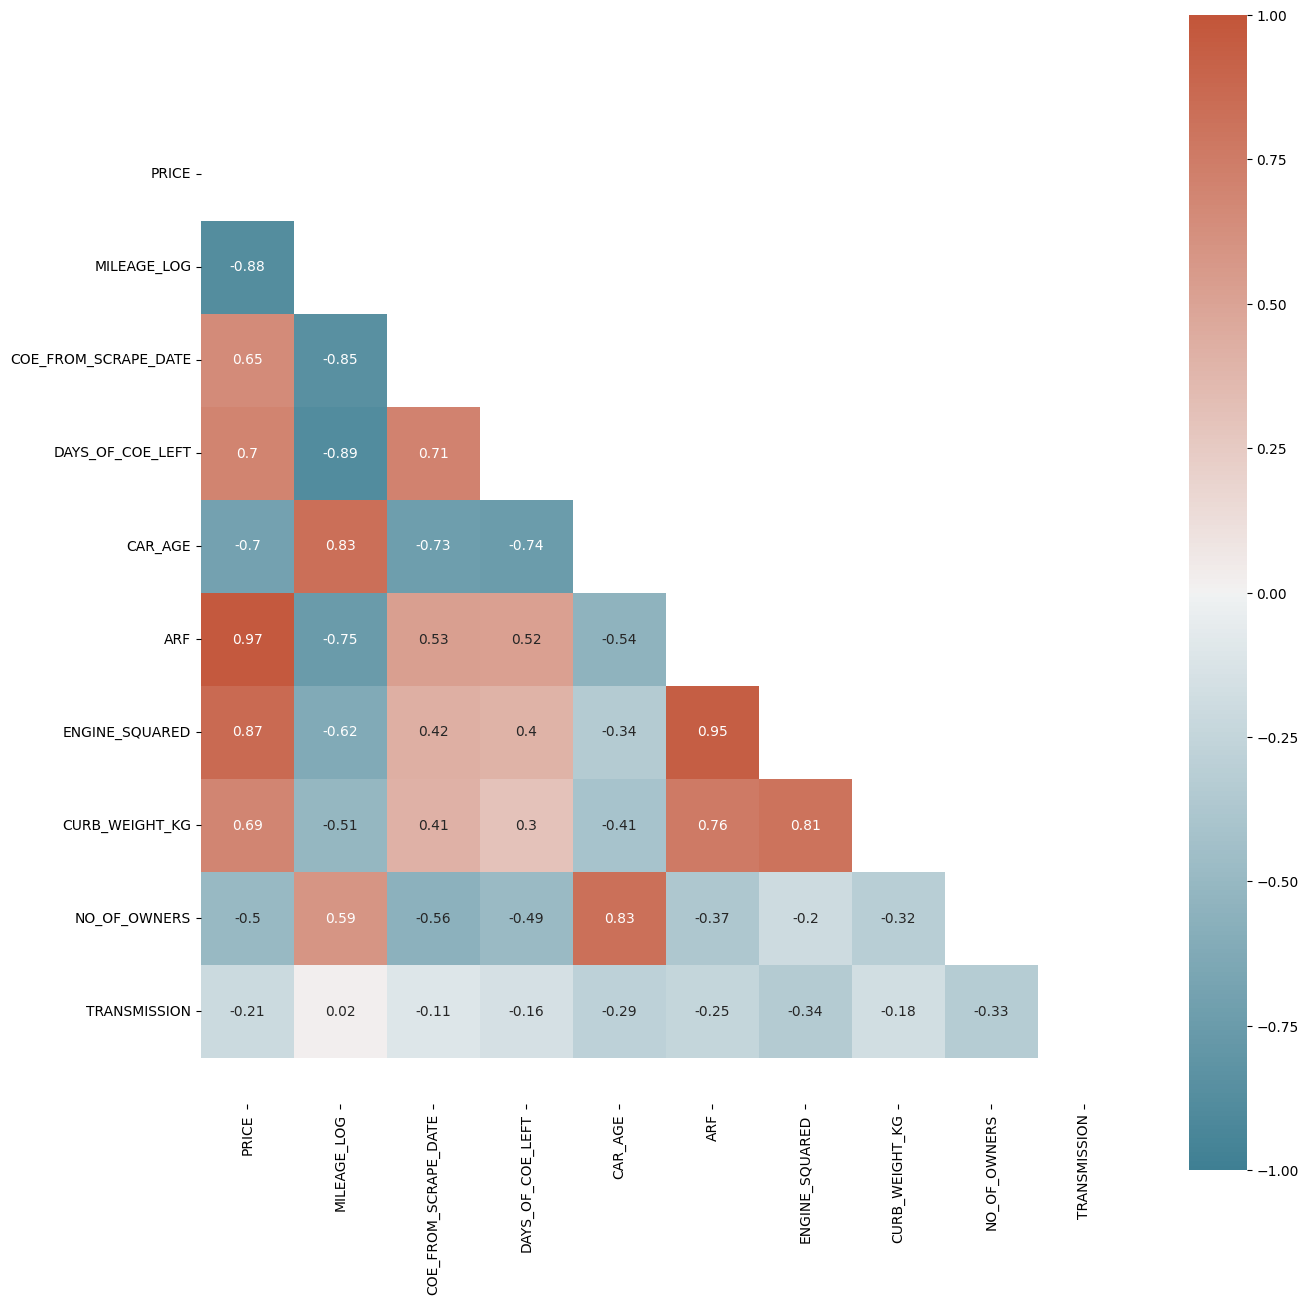

In [169]:
# Viewing Corr Matrix of Price vs Independent Variables (only logged mileage and squared engine CC)

data = df_price_no_brands_mileage_logged_squared_engine_cap.corr()

plot_corr_matrix_heatmap(data)

### Section 3.2.3: Logged Price with Logged Mileage and Squared Engine CC

In [170]:
df_logged_price_no_brands_mileage_logged_squared_engine_cap = df_price_no_brands_mileage_logged_squared_engine_cap.copy()

In [171]:
# Logging Price
df_logged_price_no_brands_mileage_logged_squared_engine_cap['PRICE_LOG'] =\
df_logged_price_no_brands_mileage_logged_squared_engine_cap['PRICE'].apply(np.log)

In [173]:
# Rearrange columns
df_logged_price_no_brands_mileage_logged_squared_engine_cap = \
df_logged_price_no_brands_mileage_logged_squared_engine_cap[['PRICE_LOG', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'ARF', 'ENGINE_SQUARED', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION']]

In [174]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_logged_price_no_brands_mileage_logged_squared_engine_cap[ ['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'ARF', 'ENGINE_SQUARED', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
Y = df_logged_price_no_brands_mileage_logged_squared_engine_cap['PRICE_LOG'].astype(float)


# model / fit / summarize
print(linear_regression_analysis(X, Y))

                            OLS Regression Results                            
Dep. Variable:              PRICE_LOG   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     4690.
Date:                Sun, 15 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:04:47   Log-Likelihood:                -367.07
No. Observations:                5888   AIC:                             754.1
Df Residuals:                    5878   BIC:                             821.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.5260 

In [175]:
print(random_forest_analysis(X, Y))

{'RMSE': 0.04833865609272901, 'R^2': 0.9956937438472531}


### Section 3.2.3: Logged Price with Logged Mileage only (no engine squared)

In [176]:
df_logged_price_no_brands_only_mileage_logged = df_price_no_brands_only_mileage_logged.copy()

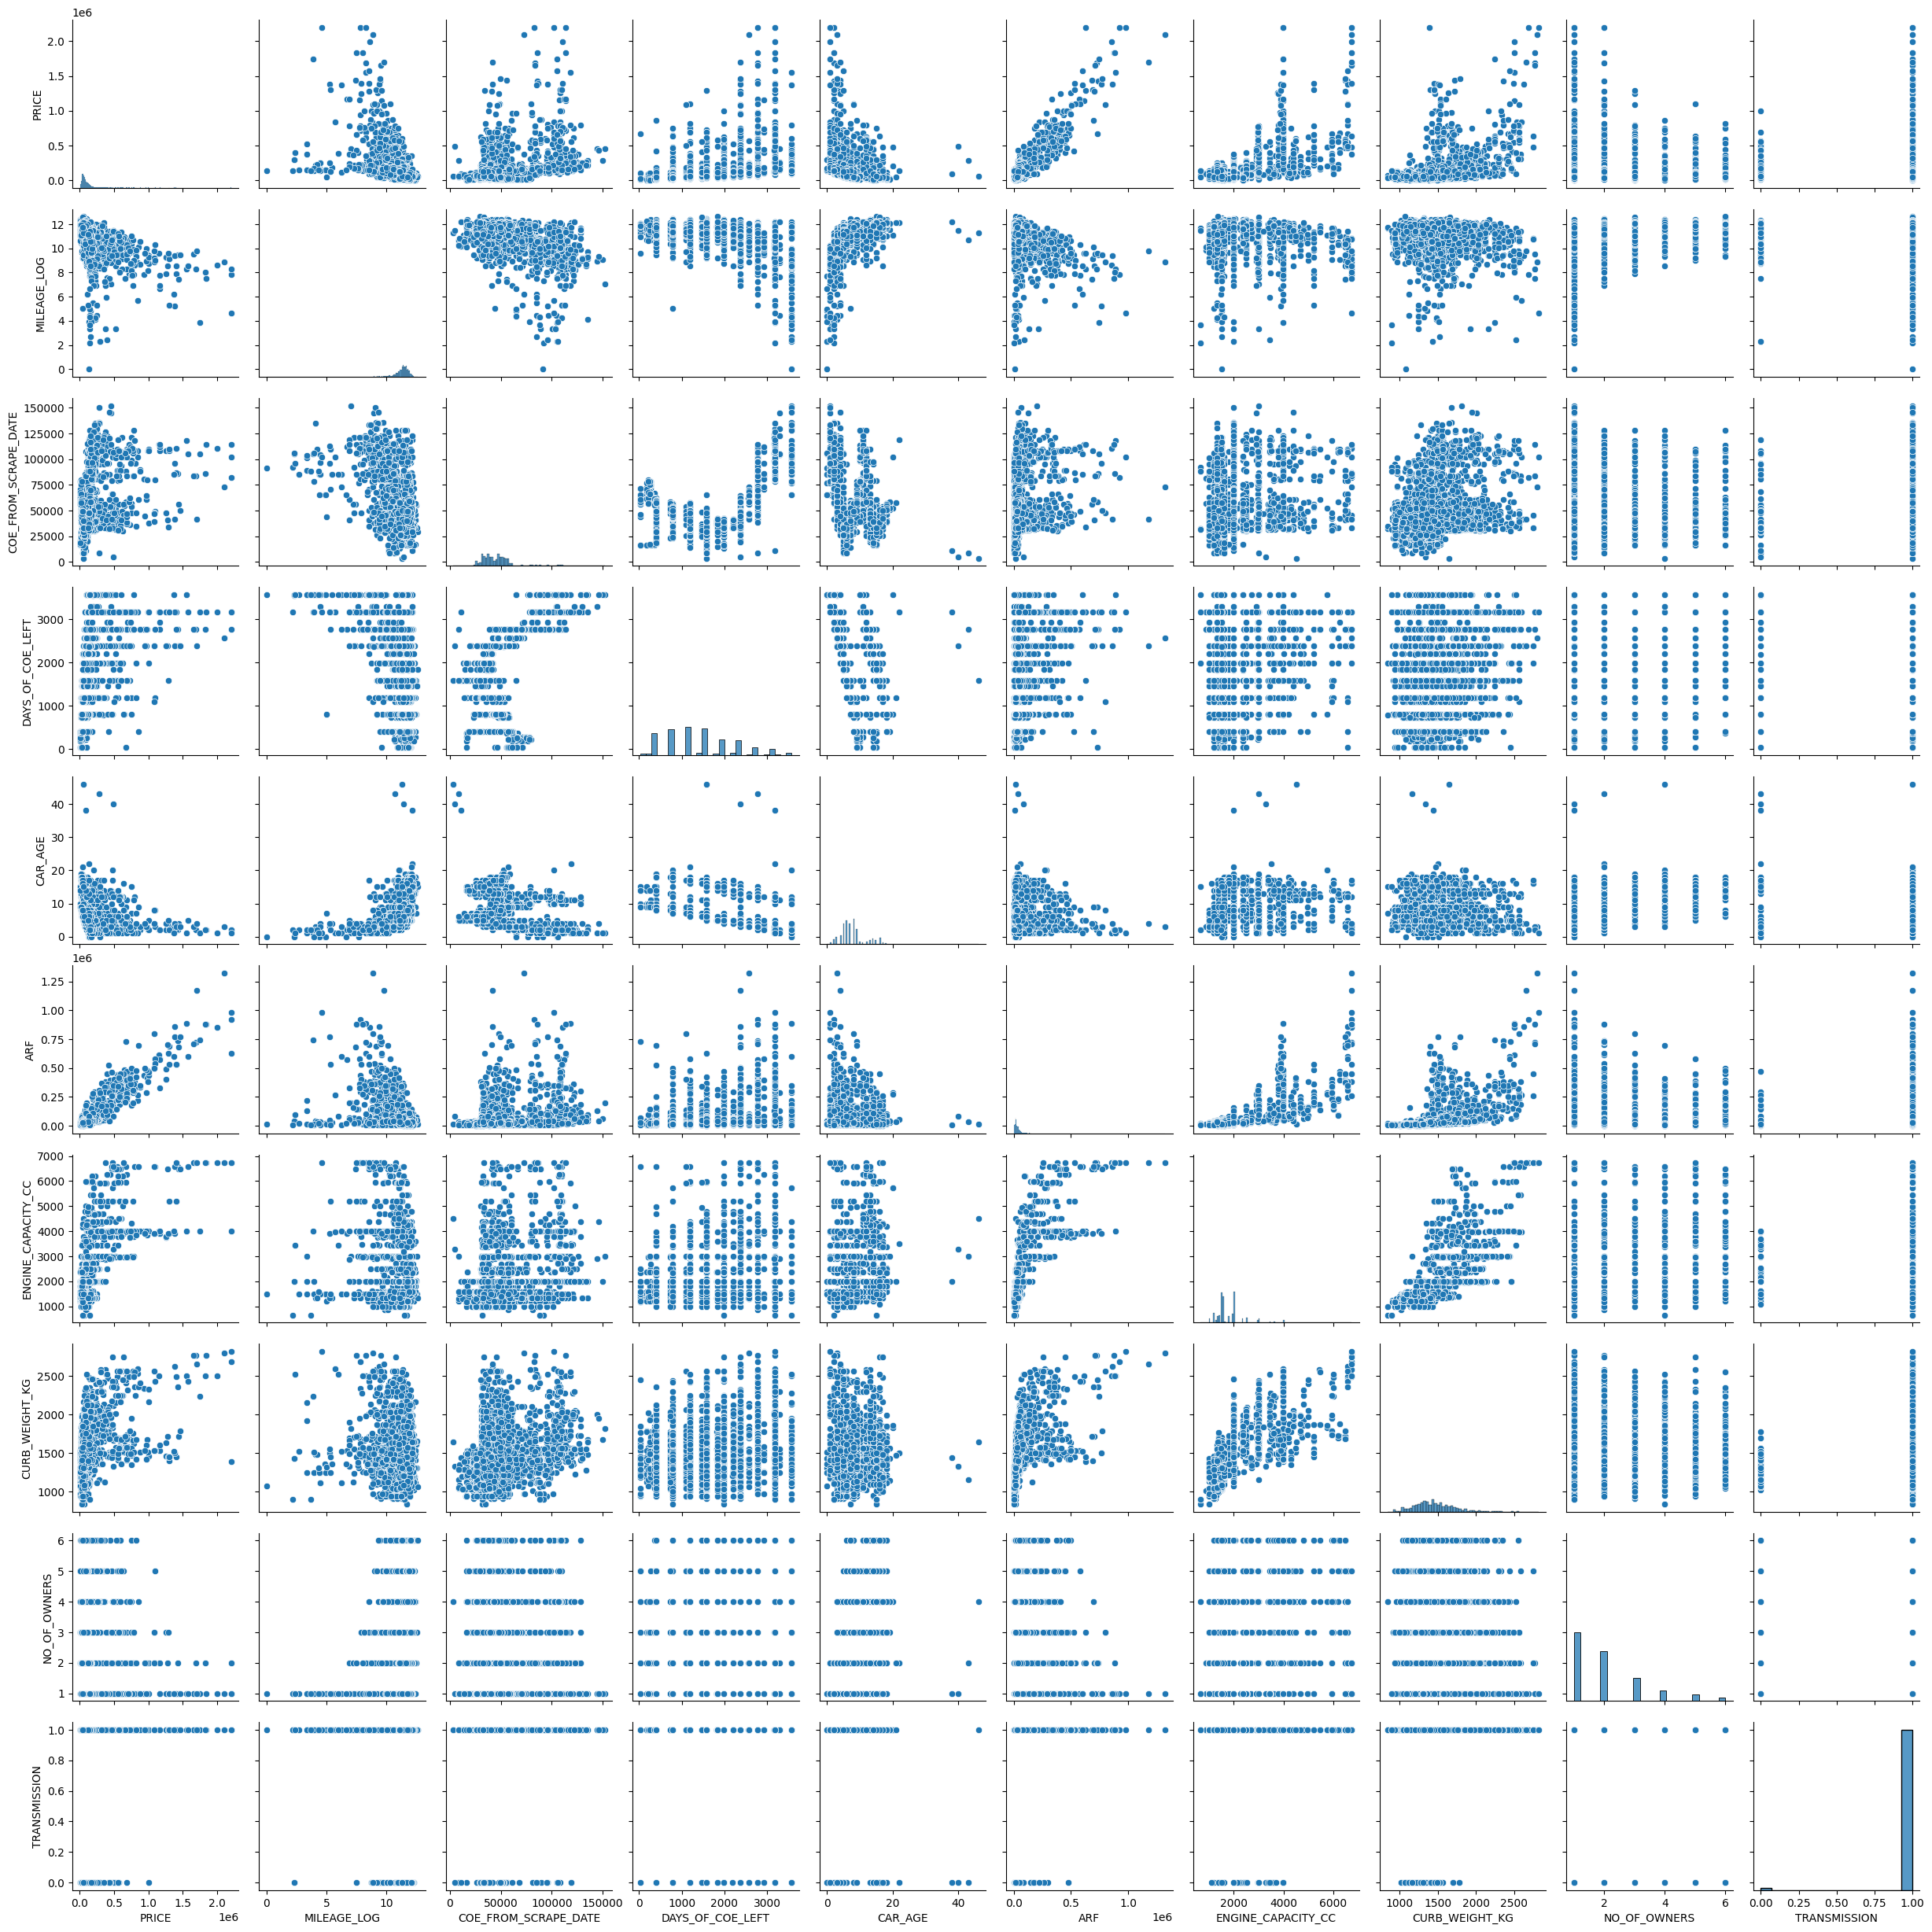

In [177]:
sns.pairplot(df_logged_price_no_brands_only_mileage_logged);
plt.savefig("log_price_and_mileage.png")

In [178]:
# Logging Price
df_logged_price_no_brands_only_mileage_logged['PRICE'] = df_logged_price_no_brands_only_mileage_logged['PRICE'].apply(np.log)

# Renaming column
df_logged_price_no_brands_only_mileage_logged.rename(columns={'PRICE':'PRICE_LOG'},inplace=True)

In [179]:
df_logged_price_no_brands_only_mileage_logged.columns

Index(['PRICE_LOG', 'MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'ARF', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'],
      dtype='object')

In [180]:
df_logged_price_no_brands_only_mileage_logged.head()

PRICE_LOG  MILEAGE_LOG  COE_FROM_SCRAPE_DATE  DAYS_OF_COE_LEFT  CAR_AGE  \
1  11.184421    12.025749               56206.0             792.0      8.0   
3  12.175036    11.337238               40714.0            2376.0     13.0   
4  10.278081    11.775290               47889.0             396.0      8.0   
5  10.733959    11.710956               54200.0             792.0      8.0   
6  10.302264    11.337381               61103.0             396.0      9.0   

       ARF  ENGINE_CAPACITY_CC  CURB_WEIGHT_KG  NO_OF_OWNERS  TRANSMISSION  
1  38249.0              2261.0          1560.0           1.0             0  
3  48853.0              2979.0          1495.0           3.0             0  
4   7865.0              1496.0          1130.0           2.0             1  
5  27026.0              1395.0          1450.0           2.0             1  
6  21706.0              2498.0          1659.0           1.0             1

In [182]:
# Slicing Data into Independent Variables (Features) and Dependent Variable (Target)
X = df_logged_price_no_brands_only_mileage_logged[['MILEAGE_LOG', 'COE_FROM_SCRAPE_DATE', 'DAYS_OF_COE_LEFT',
       'CAR_AGE', 'ARF', 'ENGINE_CAPACITY_CC', 'CURB_WEIGHT_KG',
       'NO_OF_OWNERS', 'TRANSMISSION'] ].astype(float)
Y = df_logged_price_no_brands_only_mileage_logged['PRICE_LOG'].astype(float)


# model / fit / summarize
print(linear_regression_analysis(X, Y))

                            OLS Regression Results                            
Dep. Variable:              PRICE_LOG   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     4849.
Date:                Sun, 15 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:05:41   Log-Likelihood:                -281.00
No. Observations:                5888   AIC:                             582.0
Df Residuals:                    5878   BIC:                             648.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.5439 

In [183]:
print(random_forest_analysis(X, Y))

{'RMSE': 0.04833922467627049, 'R^2': 0.9956936425419636}
